# Tasks

## TODO
* normalize the data - don't normalize the target var and don't normalize the test set
* look at column correlations
* remove correlated columns
* basic linear regression
* boosting model
* neural network model - total_solar_area/total_area as target variable
* consider 2 models - 1 predicting residential and 1 predicting non-residential
* class imbalance - classifier first then regression

## Completed
* look at data distributions
* impute n/a and missing data
* neural network model - total_solar_area as target variable

# Paper
* explain data inputs

# Setup

In [41]:
#Import Python libraries
from sklearn.model_selection import train_test_split,\
StratifiedKFold,\
RandomizedSearchCV,\
GridSearchCV
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

#actually used in this script
#Import Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler
import tensorflow as tf
import pickle
import seaborn as sns
from xgboost import XGBRegressor
from IPython.core.interactiveshell import InteractiveShell

#Set options for notebook display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
InteractiveShell.ast_node_interactivity = 'all'

#Set seed for reproducability
seed = 111

In [2]:
#Define functions
#Set of functions for data cleaning
class clean():
    '''
    Functions used to clean data sets. 
    to_binary: convert features consisting of only yes/no values to a binary indicator
    identify_uniform: Remove columns that contain only one value (ignoring N/A)
    identify_diverse_cat: Identify and/or delete columns above a specified limit of unique values
    lable_encoding: Label encode categorical variables
    
    '''
    
    def to_binary(df):
        '''
        Convert features consisting of only yes/no values to a binary indicator
        to_binary(df) --> df with yes/no columns converted to 1/0
        '''
        for col in df:
            if len(df[col].unique() == 2) and not df[col].isna().values.any():
                if 'No' in df[col].unique() and 'Yes' in df[col].unique():
                    df[col] = np.where(df[col] == 'No', 0, 1)
                if 'FALSE' in df[col].unique() and 'TRUE' in df[col].unique():
                    df[col] = np.where(df[col] == 'FALSE', 0, 1)
        return(df)
    
    def convert_to_float_try_except(col):
        '''
        Convert variable to float, with try-except loop to catch any type errors and set errors to zero
        convert_to_float_try_except(df, col) --> df with column converted to float
        '''
        try:
            new_col = float(col)
        except ValueError:
            new_col = 0
        new_col = float(new_col)
        return(new_col)

    def identify_uniform(df):
        '''
        Identify features that contain only one value (ignoring N/A)
        identify_uniform(df) --> list of uniform columns
        '''
        uniform_vars = []
        for col in df.columns:
            if len((df[col][df[col] != 'nan']).value_counts()) <= 1:
                uniform_vars.append(col)
        print('The following features are uniform:\n', uniform_vars)
        
        return(uniform_vars)
    
    def identify_diverse_cat(df, limit, delete):
        '''
        Identify and/or delete columns above a specified limit of unique values
        identify_diverse_cat(df, limit, delete) --> df
        '''
        cat_cols = list(df.select_dtypes(exclude=[np.number]).columns.values)
        
        for col in cat_cols:
            num_unique = len(list(df[col].unique()))
            if num_unique >= limit:
                if delete:
                    df = df.drop([col], axis=1)
                    print(f'{col} column was deleted becuase it had {num_unique} categories')
                else:
                    print(f'{col} column has {num_unique} categories and should be binned or transformed')
        return(df)
                
    
    def label_encoding(df):
        '''
        Label encode categorical variables
        label_encoding(df) --> df with categorical features label encoded
        '''
        label_encoder = LabelEncoder()
        categorical_list = list(df.select_dtypes(exclude=[np.number]).columns)
        for col in categorical_list:
            df[col] = df[col].apply(str)
            df[col] = label_encoder.fit_transform(df[col])
        return(df)

#Set of functions for hyper parameter turning for CatBoost, XGBoost, and Random Forest models
class parameter_tuning():
    '''
    A set of functions to assist with hyper parameter tuning for models
    Functions: randomsearch, gridsearch
    '''
    def randomsearch(seed, x, y, random_grid, model):
        '''
        Run a random search on parameters for randomforest (model='rf'), xgboost (model='xgb'),
        and catboost (model='catboost') models
        randomsearch(seed, x, y, model) --> best_params
        '''
        if model == 'rf':
            estimator = RandomForestClassifier()         
            
        elif model == 'xgboost':
            estimator = XGBClassifier(loss_function='Logloss', random_seed=seed)
            
        elif model == 'catboost':
            estimator = CatBoostClassifier(loss_function='Logloss', random_seed=seed)
       
        strat_kfold = StratifiedKFold(n_splits = 4, shuffle = True, random_state = seed)
        scoring = make_scorer(recall_score)
        random_search = RandomizedSearchCV(estimator=estimator, param_distributions=random_grid,
                                           n_iter=100, cv=strat_kfold.split(x, y), verbose=3, random_state=seed,
                                           n_jobs=-1, scoring = scoring)
        random_search.fit(x, y)
        return(random_search.best_params_)
    
    def gridsearch(seed, x, y, random_grid, model):
        '''
        Run a full grid search on parameters for randomforest (model='rf'), xgboost (model='xgb'),
        and catboost (model='catboost') models
        gridsearch(seed, x, y, model) --> best_params
        '''
        if model == 'rf':
            estimator = RandomForestClassifier()

        elif model == 'xgboost':
            estimator = XGBClassifier()
            
        elif model == 'catboost':
            estimator = CatBoostClassifier()
       
        strat_kfold = StratifiedKFold(n_splits = 4, shuffle = True, random_state = seed)
        scoring = make_scorer(recall_score)
        grid_search = GridSearchCV(estimator=estimator, param_grid=random_grid, cv=strat_kfold.split(x, y),
                                   verbose=3, n_jobs=-1, scoring = scoring)
        grid_search.fit(x, y)
        return(grid_search.best_params_)

#Set of functions for Machine Learning models
class models():
    
    '''
    Define Machine Learning models
    Functions: catboost_model, rf_model
    Will use recall as the evaluation metric because the cost of a false negative is low and we need to capture all
    potential churners
    '''
    def catboost_model(x_train, x_test, y_train, y_test, seed, use_best_mod, **kwargs):
        '''
        Define CatBoost Model
        catboost_model(x_train, x_test, y_train, y_test, seed, use_best_mod, **kwargs) --> model
        '''
        combined = pd.concat([x_train, x_test])
        cat_feat_index = np.where(combined.dtypes == object)[0]
        model = CatBoostClassifier(**kwargs, use_best_model=True,
                                       loss_function='Logloss', eval_metric='Recall', random_seed=seed)
            
        model.fit(x_train, y_train, plot=True, cat_features=cat_feat_index, eval_set=(x_test, y_test))
        
        return(model)
    
    def rf_model(x_cat_train, y_cat_train, seed, **kwargs):
        '''
        Define Random Forest Model
        rf_model(x_cat_train, y_cat_train, seed, **kwargs) --> model
        '''
        rf_mod = RandomForestClassifier(random_state=seed, **kwargs)
        rf_mod.fit(x_cat_train, y_cat_train)
        
        return(rf_mod)
    
    def xgboost_model(x_cat_train, y_cat_train, seed, **kwargs):
        '''
        Define XGBoost Model
        xgb_model(x_cat_train, y_cat_train, seed, **kwargs) -->
        '''
        xgb = XGBClassifier(random_state=seed, **kwargs)
        xgb.fit(x_cat_train, y_cat_train)
        return(xgb)

#Set of functions to evaluate model performance
class evaluation():
    '''
    A set of functions to evaluate model performance
    Functions: predictions, scores, results
    '''
    def predictions(model, x_train, x_test):
        '''
        Use model to predict y test and train
        predictions(mode, x_train, x_test) --> y_pred_train, y_pred_test
        '''
        y_pred_train = model.predict(x_train)
        y_pred_test = model.predict(x_test)

        return(y_pred_train, y_pred_test)

    def scores(y, y_pred):
        '''
        Get model metrics
        scores(y, y_pred) --> AUC, accuracy, F1, recall, precision
        '''
        AUC = roc_auc_score(y, y_pred)
        accuracy = accuracy_score(y, y_pred)
        F1 = f1_score(y, y_pred)
        recall = recall_score(y, y_pred)
        precision = precision_score(y, y_pred)
        return(AUC, accuracy, F1, recall, precision)
    
    def results(y_train, y_test, y_pred_train, y_pred_test):
        '''
        Create train and test model metrics table
        results(y_train, y_test, y_pred_train, y_pred_test) --> final_results table
        '''
        AUC_test, accuracy_test, F1_test, recall_test, precision_test = evaluation.scores(y_test, y_pred_test)
        AUC_train, accuracy_train, F1_train, recall_train, precision_train = evaluation.scores(y_train, y_pred_train)
        final_results = {'Test': [AUC_test, accuracy_test, F1_test, recall_test, precision_test],
                        'Train': [AUC_train, accuracy_train, F1_train, recall_train, precision_train],
                        'Index Title': ['AUC','Accuracy', 'F1', 'Recall', 'Precision']}
        final_results = pd.DataFrame(final_results)
        final_results.index = final_results['Index Title']
        final_results.index.name = 'Metrics'
        del final_results['Index Title']
        return(final_results)    


In [3]:
#Define functions
def find_na_columns(df: pd.DataFrame):
    """
    Function to list columns that contain n/a's
    Input: df: pd.DataFrame
    Output: List of column names
    """
    na_cols = []
    for col in df:
        if df[col].isna().any():
            na_cols.append(col)
    return(na_cols)

#Imputation
def impute_values(train_df: pd.DataFrame, test_df: pd.DataFrame, column: str, group_column: str,  impute_value='mean'):
    """
    Function to impute missing values for numeric variables. Group column used to make imputations by mean more accurate.
    Input: train_df: pd.DataFrame, train data
            test_df: pd.DataFrame, test data
            column: str, column to impute
            group_column: str, column to group by for imputing
            impute_value: str ('mean', 'median')
    Output: dataframe with column with all missing values imputed to impute value
    """
    if impute_value == 'mean':
        subset = train_df[[column,group_column]].groupby(group_column).mean()
    elif impute_value == 'median':
        subset = train_df[[column,group_column]].groupby(group_column).median()
    elif impute_value == 'zero':
        df[column] = np.where(df[column].isna(), 0, df[column])
        return(df)
    else:
        raise Exception('That impute value is invalid. Options include mean or median.')
    subset = subset.reset_index()
    subset = subset.rename(columns={column: 'impute_val'})
    train_df = train_df.merge(subset, how='left', on=group_column)
    train_df[column] = np.where(train_df[column].isna(), train_df['impute_val'], train_df[column])
    train_df = train_df.drop('impute_val', axis=1)
    
    test_df = test_df.merge(subset, how='left', on=group_column)
    test_df[column] = np.where(test_df[column].isna(), test_df['impute_val'], test_df[column])
    test_df = test_df.drop('impute_val', axis=1)
    return(train_df, test_df)

def transformation_comparison(df: pd.DataFrame, column: str):
    """
    Function to create plots to compare log, min_max_scaler, and standard_scaler transformation of a 
    numeric column.
    
    Inputs: df: pd.DataFrame
            column: str, the name of a numeric column in the dataframe
            
    Outputs:
            None, print a plot showing a histogram of the data with different transformations
            
    Source: https://towardsdatascience.com/how-to-differentiate-between-scaling-normalization-and-log-transformations-69873d365a94
    """
    try:
        #If the column is strictly positive, use the box-cox method of power transformation
        if df[column].min() > 0:
            pt = PowerTransformer('box-cox')
        else:
            pt = PowerTransformer('yeo-johnson')
        fig, axes = plt.subplots(1,4, figsize=(15,3))
        _ = df.hist(column, ax = axes[0])
        #df['log_col'] = df[col].apply(lambda x: np.log(x+1))
        df[["log_col"]] = pd.DataFrame(pt.fit_transform(df[[column]]), columns=[column])
        _ = df.hist('log_col', ax = axes[1])
        mms = MinMaxScaler()
        df[['min_max_col']] = pd.DataFrame(mms.fit_transform(df[[column]]), columns=[column])
        _ = df.hist('min_max_col', ax = axes[2])
        ss = StandardScaler()
        df[['standar_scaler_col']] = pd.DataFrame(ss.fit_transform(df[[column]]), columns=[column])
        _ = df.hist('standar_scaler_col', ax = axes[3])
        _ = plt.show()
    except:
        raise Exception(col, ' did not plot')

def remove_correlation(df: pd.DataFrame, target: str, threshold = .8):
    """
    Function to remove correlated columns. Find the columns that have a correlation above the absolute value of the
    threshold. Remove the column that is least correlated with the target variable until there are no more highly 
    correlated columns.
    Inputs:
        df: pd.DataFrame
        target: str, column name of target variable
        threshold: float, the correlation coefficient threshold to consider significant
    Outputs:
        pd.Dataframe with least correlated column removed
        list of dropped columns
    """
    corr_cols = ['placeholder']
    dropped_cols = []
    while len(corr_cols) > 0:
        correlation_matrix = df.corr()
        corr_df = pd.DataFrame(correlation_matrix.unstack(),columns = ['correlation_coef'])
        corr_df = corr_df.reset_index()
        corr_df_significant = corr_df[((corr_df['correlation_coef'] > .8)|(corr_df['correlation_coef'] < -.8))&(corr_df['level_0'] != corr_df['level_1'])]
        corr_cols = corr_df_significant['level_0'].unique()
        if target in corr_cols:
            corr_cols.remove(target)
        if len(corr_cols) == 0:
            return(df, dropped_cols)
        subset = corr_df[(corr_df['level_0'] ==target)&(corr_df['level_1'].isin(corr_cols))]
        subset['correlation_coef'] = abs(subset['correlation_coef'])
        drop_col = subset['level_1'].loc[subset['correlation_coef'].idxmin()]
        dropped_cols.append(drop_col)
        df = df.drop(drop_col, axis=1)

    

# Data Cleaning and Preparation
* Correct data types
* Imputation (median by county)
* Remove correlated features

In [4]:
#Read in data
df = pd.read_pickle('/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/data/deepsolar_tract_clean.pkl')
#Print an overview of the data set
df.head()

,tile_count,solar_system_count,total_panel_area,fips,average_household_income,county,education_bachelor,education_college,education_doctoral,education_high_school_graduate,education_less_than_high_school,education_master,education_population,education_professional_school,employed,gini_index,heating_fuel_coal_coke,heating_fuel_electricity,heating_fuel_fuel_oil_kerosene,heating_fuel_gas,heating_fuel_housing_unit_count,heating_fuel_none,heating_fuel_other,heating_fuel_solar,land_area,per_capita_income,population,population_density,poverty_family_below_poverty_level,poverty_family_count,race_asian,race_black_africa,race_indian_alaska,race_islander,race_other,race_two_more,race_white,state,total_area,unemployed,water_area,education_less_than_high_school_rate,education_high_school_graduate_rate,education_college_rate,education_bachelor_rate,education_master_rate,education_professional_school_rate,education_doctoral_rate,race_white_rate,race_black_africa_rate,race_indian_alaska_rate,race_asian_rate,race_islander_rate,race_other_rate,race_two_more_rate,employ_rate,poverty_family_below_poverty_level_rate,heating_fuel_gas_rate,heating_fuel_electricity_rate,heating_fuel_fuel_oil_kerosene_rate,heating_fuel_coal_coke_rate,heating_fuel_solar_rate,heating_fuel_other_rate,heating_fuel_none_rate,solar_panel_area_divided_by_area,solar_panel_area_per_capita,tile_count_residential,tile_count_nonresidential,solar_system_count_residential,solar_system_count_nonresidential,total_panel_area_residential,total_panel_area_nonresidential,median_household_income,electricity_price_residential,electricity_price_commercial,electricity_price_industrial,electricity_price_transportation,electricity_price_overall,electricity_consume_residential,electricity_consume_commercial,electricity_consume_industrial,electricity_consume_total,household_count,average_household_size,housing_unit_count,housing_unit_occupied_count,housing_unit_median_value,housing_unit_median_gross_rent,lat,lon,elevation,heating_design_temperature,cooling_design_temperature,earth_temperature_amplitude,frost_days,air_temperature,relative_humidity,daily_solar_radiation,atmospheric_pressure,wind_speed,earth_temperature,heating_degree_days,cooling_degree_days,age_18_24_rate,age_25_34_rate,age_more_than_85_rate,age_75_84_rate,age_35_44_rate,age_45_54_rate,age_65_74_rate,age_55_64_rate,age_10_14_rate,age_15_17_rate,age_5_9_rate,household_type_family_rate,dropout_16_19_inschool_rate,occupation_construction_rate,occupation_public_rate,occupation_information_rate,occupation_finance_rate,occupation_education_rate,occupation_administrative_rate,occupation_manufacturing_rate,occupation_wholesale_rate,occupation_retail_rate,occupation_transportation_rate,occupation_arts_rate,occupation_agriculture_rate,occupancy_vacant_rate,occupancy_owner_rate,mortgage_with_rate,transportation_home_rate,transportation_car_alone_rate,transportation_walk_rate,transportation_carpool_rate,transportation_motorcycle_rate,transportation_bicycle_rate,transportation_public_rate,travel_time_less_than_10_rate,travel_time_10_19_rate,travel_time_20_29_rate,travel_time_30_39_rate,travel_time_40_59_rate,travel_time_60_89_rate,health_insurance_public_rate,health_insurance_none_rate,age_median,travel_time_average,voting_2016_dem_percentage,voting_2016_gop_percentage,voting_2016_dem_win,voting_2012_dem_percentage,voting_2012_gop_percentage,voting_2012_dem_win,number_of_years_of_education,diversity,number_of_solar_system_per_household,incentive_count_residential,incentive_count_nonresidential,incentive_residential_state_level,incentive_nonresidential_state_level,net_metering,feedin_tariff,cooperate_tax,property_tax,sales_tax,rebate,avg_electricity_retail_rate
0,0.0,0.0,0.000000,27145011200,70352.789869,Stearns County,569,1690,13,1757,336,157,4548,26,3569,0.3490,200,448,98,1720,2527,10,51,0,147.73120,26999.0,6577,44.52005,85,1911,28,19,16,0,6,88,6420,mn,154.37190,136,6.640769,0.073879,0.386324,0.371592,0.125110,0.034521,0.005717,0.002858,0.97

In [5]:
len(df['fips'].unique())

72537

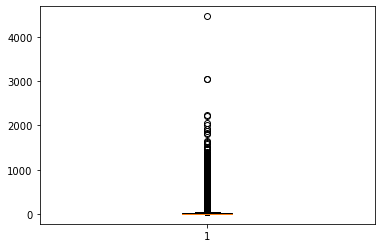

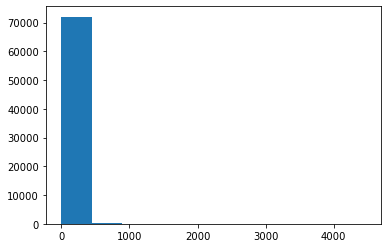

count    72537.000000
mean        30.255787
std         86.337406
min          0.000000
25%          1.000000
50%          4.000000
75%         22.000000
max       4468.000000
Name: tile_count, dtype: float64

0.77557660228573

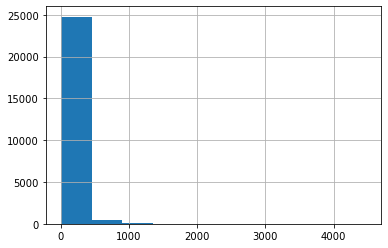

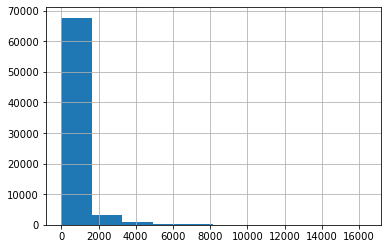

count    72513.000000
mean       359.605537
std        918.878666
min          0.000000
25%          0.000000
50%         20.780833
75%        212.018024
max      16357.357979
Name: solar_panel_area_divided_by_area, dtype: float64

In [6]:
_ = plt.boxplot(df['tile_count'])
plt.show()
_ = plt.hist(df['tile_count'])
plt.show()
df['tile_count'].describe()
len(df[df['tile_count'] > 0])/len(df)
df_tiles = df[df['tile_count'] >10]
_ = df_tiles['tile_count'].hist()
plt.show()
_ = df['solar_panel_area_divided_by_area'].hist()
plt.show()
df['solar_panel_area_divided_by_area'].describe()

In [7]:
df['solar_panel_area_divided_by_area'].describe()

count    72513.000000
mean       359.605537
std        918.878666
min          0.000000
25%          0.000000
50%         20.780833
75%        212.018024
max      16357.357979
Name: solar_panel_area_divided_by_area, dtype: float64

In [8]:
#Explore columns and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72537 entries, 0 to 72536
Columns: 168 entries, tile_count to avg_electricity_retail_rate
dtypes: bool(2), float64(117), int64(46), object(3)
memory usage: 92.0+ MB


/opt/anaconda3/envs/mlenv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


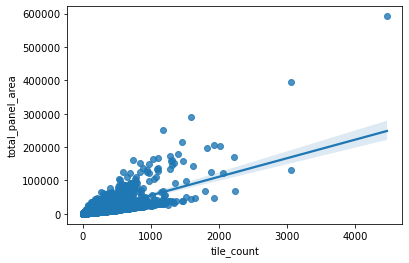

In [9]:
#plt.scatter(df['tile_count'], df['total_panel_area'])
_ = sns.regplot(df['tile_count'],df['total_panel_area'])

In [10]:
len(df[df['total_area'].isna()])

24

In [11]:
#Define variables that may potentially provide additional information about the target variable. Will need
#to remove these look ahead variables so the model is not cheating when it makes its predictions
look_ahead_vars = ['tile_count', 'solar_system_count', 'tile_count_residential', 'tile_count_nonresidential',
                  'solar_system_count_residential', 'solar_system_count_nonresidential', 'total_panel_area',
                   'total_panel_area_residential', 'total_panel_area_nonresidential',
                   'solar_panel_area_divided_by_area', 'solar_panel_area_per_capita',
                   'number_of_solar_system_per_household']


In [12]:
#Examine which look ahead variables are correlated
# res_cols = [col for col in look_ahead_vars if 'residential' in col and 'non' not in col]
# correlation_matrix = x_train[res_cols].corr()
# _ = sns.heatmap(correlation_matrix, annot=True)
# plt.show()
# nonres_cols = [col for col in look_ahead_vars if 'nonresidential' in col]
# correlation_matrix = x_train[nonres_cols].corr()
# _ = sns.heatmap(correlation_matrix, annot=True)
# plt.show()

In [13]:
#Might actually remove correlated columns in combination with the n/as and the distributions
# correlation_matrix = train_data.corr()
# corr_df = pd.DataFrame(correlation_matrix.unstack(),columns = ['correlation_coef'])
# corr_df = corr_df.reset_index()
# corr_df_significant = corr_df[((corr_df['correlation_coef'] > .8)|(corr_df['correlation_coef'] < -.8))&(corr_df['level_0'] != corr_df['level_1'])]
# corr_cols = corr_df_significant['level_0'].unique()



In [14]:
#Print list of categorical columns
cat_cols = list(df.select_dtypes(exclude=[np.number]).columns.values)
cat_cols

['county',
 'state',
 'electricity_price_transportation',
 'voting_2016_dem_win',
 'voting_2012_dem_win']

In [15]:
df['electricity_price_transportation'] = pd.to_numeric(df['electricity_price_transportation'],errors='coerce')

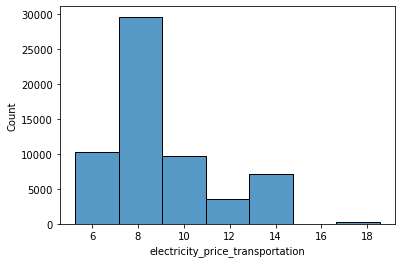

In [16]:
_ = sns.histplot(df['electricity_price_transportation'], bins=7)
_ = plt.show()

In [17]:
df['voting_2016_dem_win'] = np.where(df['voting_2016_dem_win'] == True, 1, 
                                    np.where(df['voting_2016_dem_win'] == False, 0, -1))
df['voting_2016_dem_win'].describe()

count    72537.000000
mean         0.540097
std          0.498393
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: voting_2016_dem_win, dtype: float64

In [18]:
df['voting_2012_dem_win'] = np.where(df['voting_2012_dem_win'] == True, 1, 
                                    np.where(df['voting_2012_dem_win'] == False, 0, -1))
df['voting_2012_dem_win'].describe()

count    72537.000000
mean         0.490108
std          0.499906
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: voting_2012_dem_win, dtype: float64

In [19]:
#Shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

#define the target variable
target_var = 'total_panel_area_residential'

look_ahead_vars.remove(target_var)
df = df.drop(look_ahead_vars, axis=1)
#df = df.drop(uninformative_vars, axis=1)


#Separate data into x and y
x = df[df.columns.difference([target_var])]
y = df[target_var]

#Split data into train and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

train_data = pd.concat([x_train, pd.DataFrame(y_train.values, columns = [target_var], index = y_train.index)], axis=1)
train_data.head()

test_data = pd.concat([x_test, pd.DataFrame(y_test.values, columns = [target_var], index = y_test.index)], axis=1)


,age_10_14_rate,age_15_17_rate,age_18_24_rate,age_25_34_rate,age_35_44_rate,age_45_54_rate,age_55_64_rate,age_5_9_rate,age_65_74_rate,age_75_84_rate,age_median,age_more_than_85_rate,air_temperature,atmospheric_pressure,average_household_income,average_household_size,avg_electricity_retail_rate,cooling_degree_days,cooling_design_temperature,cooperate_tax,county,daily_solar_radiation,diversity,dropout_16_19_inschool_rate,earth_temperature,earth_temperature_amplitude,education_bachelor,education_bachelor_rate,education_college,education_college_rate,education_doctoral,education_doctoral_rate,education_high_school_graduate,education_high_school_graduate_rate,education_less_than_high_school,education_less_than_high_school_rate,education_master,education_master_rate,education_population,education_professional_school,education_professional_school_rate,electricity_consume_commercial,electricity_consume_industrial,electricity_consume_residential,electricity_consume_total,electricity_price_commercial,electricity_price_industrial,electricity_price_overall,electricity_price_residential,electricity_price_transportation,elevation,employ_rate,employed,feedin_tariff,fips,frost_days,gini_index,health_insurance_none_rate,health_insurance_public_rate,heating_degree_days,heating_design_temperature,heating_fuel_coal_coke,heating_fuel_coal_coke_rate,heating_fuel_electricity,heating_fuel_electricity_rate,heating_fuel_fuel_oil_kerosene,heating_fuel_fuel_oil_kerosene_rate,heating_fuel_gas,heating_fuel_gas_rate,heating_fuel_housing_unit_count,heating_fuel_none,heating_fuel_none_rate,heating_fuel_other,heating_fuel_other_rate,heating_fuel_solar,heating_fuel_solar_rate,household_count,household_type_family_rate,housing_unit_count,housing_unit_median_gross_rent,housing_unit_median_value,housing_unit_occupied_count,incentive_count_nonresidential,incentive_count_residential,incentive_nonresidential_state_level,incentive_residential_state_level,land_area,lat,lon,median_household_income,mortgage_with_rate,net_metering,number_of_years_of_education,occupancy_owner_rate,occupancy_vacant_rate,occupation_administrative_rate,occupation_agriculture_rate,occupation_arts_rate,occupation_construction_rate,occupation_education_rate,occupation_finance_rate,occupation_information_rate,occupation_manufacturing_rate,occupation_public_rate,occupation_retail_rate,occupation_transportation_rate,occupation_wholesale_rate,per_capita_income,population,population_density,poverty_family_below_poverty_level,poverty_family_below_poverty_level_rate,poverty_family_count,property_tax,race_asian,race_asian_rate,race_black_africa,race_black_africa_rate,race_indian_alaska,race_indian_alaska_rate,race_islander,race_islander_rate,race_other,race_other_rate,race_two_more,race_two_more_rate,race_white,race_white_rate,rebate,relative_humidity,sales_tax,state,total_area,transportation_bicycle_rate,transportation_car_alone_rate,transportation_carpool_rate,transportation_home_rate,transportation_motorcycle_rate,transportation_public_rate,transportation_walk_rate,travel_time_10_19_rate,travel_time_20_29_rate,travel_time_30_39_rate,travel_time_40_59_rate,travel_time_60_89_rate,travel_time_average,travel_time_less_than_10_rate,unemployed,voting_2012_dem_percentage,voting_2012_dem_win,voting_2012_gop_percentage,voting_2016_dem_percentage,voting_2016_dem_win,voting_2016_gop_percentage,water_area,wind_speed,total_panel_area_residential
40203,0.123994,0.053005,0.099858,0.142451,0.076195,0.113109,0.074775,0.135826,0.058211,0.023190,23.9,0.000000,12.5,100.2,18449.945355,2.31,11.88,2131.0,29.87,0,Baltimore city,3.85,0.057305,0.865854,12.5,19.84,12,0.011639,179,0.173618,0,0.000000,417,0.404462,423,0.410281,0,0.000000,1031,0,0.000000,10019,36686,1012,47717,11.00,8.53,12.07,13.82,8.34,133.0,0.727132,469,0,24510180100,81.0,0.4536,0.087553,0.780407,2660.0,-4.96,0,0.000000,345,0.377049,0,0.000000,544,0.594536,915,5,0.005464,21,0.022951,0,0.0,915,0.478689,1065,472.0,141100.0,915,39,28,21,13,0.131898,39.292,-76.631

In [20]:
na_cols = find_na_columns(df)
na_cols

['average_household_income',
 'gini_index',
 'land_area',
 'per_capita_income',
 'population_density',
 'total_area',
 'water_area',
 'education_less_than_high_school_rate',
 'education_high_school_graduate_rate',
 'education_college_rate',
 'education_bachelor_rate',
 'education_master_rate',
 'education_professional_school_rate',
 'education_doctoral_rate',
 'race_white_rate',
 'race_black_africa_rate',
 'race_indian_alaska_rate',
 'race_asian_rate',
 'race_islander_rate',
 'race_other_rate',
 'race_two_more_rate',
 'employ_rate',
 'poverty_family_below_poverty_level_rate',
 'heating_fuel_gas_rate',
 'heating_fuel_electricity_rate',
 'heating_fuel_fuel_oil_kerosene_rate',
 'heating_fuel_coal_coke_rate',
 'heating_fuel_solar_rate',
 'heating_fuel_other_rate',
 'heating_fuel_none_rate',
 'median_household_income',
 'electricity_price_transportation',
 'average_household_size',
 'housing_unit_median_value',
 'housing_unit_median_gross_rent',
 'lat',
 'lon',
 'elevation',
 'heating_desig

In [21]:
for col in na_cols:
    train_data, test_data = impute_values(train_data, test_data, col,'county', 'median')

In [22]:
na_cols = find_na_columns(train_data)
na_cols

['air_temperature',
 'atmospheric_pressure',
 'cooling_degree_days',
 'cooling_design_temperature',
 'daily_solar_radiation',
 'dropout_16_19_inschool_rate',
 'earth_temperature',
 'earth_temperature_amplitude',
 'electricity_price_transportation',
 'elevation',
 'frost_days',
 'heating_degree_days',
 'heating_design_temperature',
 'housing_unit_median_gross_rent',
 'housing_unit_median_value',
 'land_area',
 'lat',
 'lon',
 'median_household_income',
 'population_density',
 'relative_humidity',
 'total_area',
 'voting_2012_dem_percentage',
 'voting_2012_gop_percentage',
 'voting_2016_dem_percentage',
 'voting_2016_gop_percentage',
 'water_area',
 'wind_speed']

In [23]:
for col in na_cols:
    print(col, ' has ', len(train_data[train_data[col].isna()]), ' missing')

air_temperature  has  8  missing
atmospheric_pressure  has  8  missing
cooling_degree_days  has  8  missing
cooling_design_temperature  has  8  missing
daily_solar_radiation  has  8  missing
dropout_16_19_inschool_rate  has  1  missing
earth_temperature  has  8  missing
earth_temperature_amplitude  has  8  missing
electricity_price_transportation  has  4269  missing
elevation  has  8  missing
frost_days  has  8  missing
heating_degree_days  has  8  missing
heating_design_temperature  has  8  missing
housing_unit_median_gross_rent  has  2  missing
housing_unit_median_value  has  1  missing
land_area  has  2  missing
lat  has  8  missing
lon  has  8  missing
median_household_income  has  1  missing
population_density  has  2  missing
relative_humidity  has  8  missing
total_area  has  2  missing
voting_2012_dem_percentage  has  4899  missing
voting_2012_gop_percentage  has  4899  missing
voting_2016_dem_percentage  has  2  missing
voting_2016_gop_percentage  has  2  missing
water_area  h

In [24]:
#Drop the columns that had almost 5,000 rows of missing data.
drop_cols = ['electricity_price_transportation','voting_2012_dem_percentage','voting_2012_gop_percentage']
train_data = train_data.drop(drop_cols, axis=1)
test_data = test_data.drop(drop_cols, axis=1)

In [25]:
'voting_2012_dem_percentage' in train_data.columns

False

In [26]:
len(train_data)

58029

In [27]:
#Drop any remaining rows with n/a values
train_data = train_data.dropna()
len(train_data)
test_data = test_data.dropna()
len(test_data)

58015

14504

In [28]:
#Define variables that are uniformative for what the model is trying to predict
uninformative_vars = ['fips', 'county', 'state']
#'lat', 'lon'
train_data = train_data.drop(uninformative_vars, axis=1)
test_data = test_data.drop(uninformative_vars, axis=1)

In [23]:
# # corr_cols = ['placeholder']
# # dropped_cols = []
# # while len(corr_cols) > 0:
# correlation_matrix = train_data.corr()
# corr_df = pd.DataFrame(correlation_matrix.unstack(),columns = ['correlation_coef'])
# corr_df = corr_df.reset_index()
# corr_df_significant = corr_df[((corr_df['correlation_coef'] > .8)|(corr_df['correlation_coef'] < -.8))&(corr_df['level_0'] != corr_df['level_1'])]
# corr_cols = corr_df_significant['level_0'].unique()
# if target_var in corr_cols:
#     corr_cols.remove(target_var)
# subset = corr_df[(corr_df['level_0'] ==target_var)&(corr_df['level_1'].isin(corr_cols))]
# subset['correlation_coef'] = abs(subset['correlation_coef'])

# drop_col = subset['level_1'].loc[subset['correlation_coef'].idxmin()]
# drop_col
# # dropped_cols.append(drop_col)
# # df = df.drop(drop_col, axis=1)


In [29]:
correlation_matrix = train_data.corr()
corr_df = pd.DataFrame(correlation_matrix.unstack(),columns = ['correlation_coef'])
corr_df = corr_df.reset_index()
corr_df_significant = corr_df[((corr_df['correlation_coef'] > .8)|(corr_df['correlation_coef'] < -.8))&(corr_df['level_0'] != corr_df['level_1'])]
len(corr_df_significant['level_0'].unique())

In [32]:
train_data, dropped_cols = remove_correlation(train_data, target_var)

/var/folders/8w/yzz7q0p146x4qrt7dwp0mhy40000gn/T/ipykernel_29091/238850017.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['correlation_coef'] = abs(subset['correlation_coef'])


In [25]:
test_data = test_data.drop(dropped_cols, axis=1)

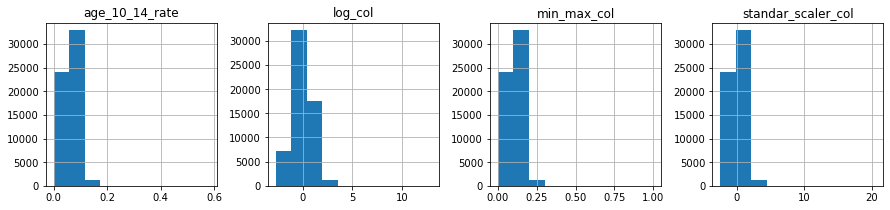

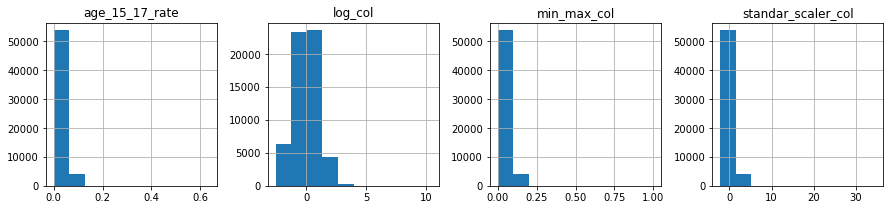

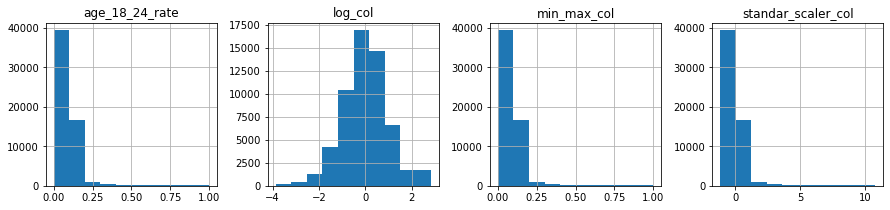

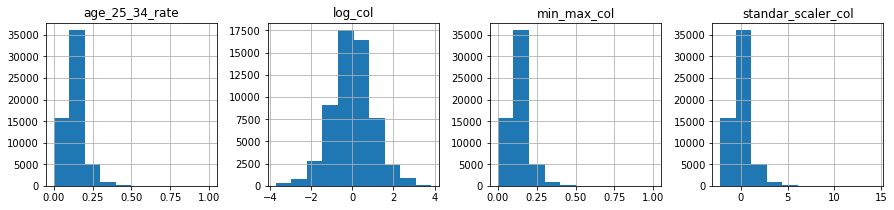

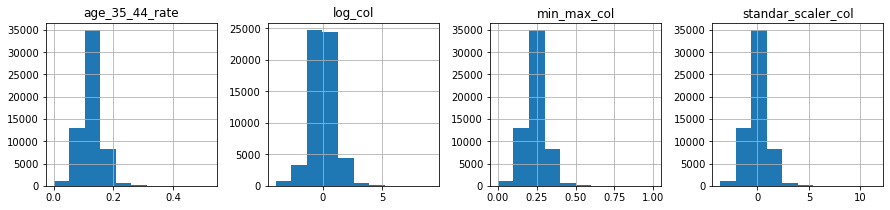

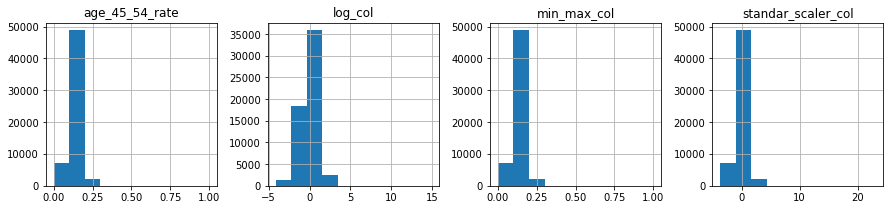

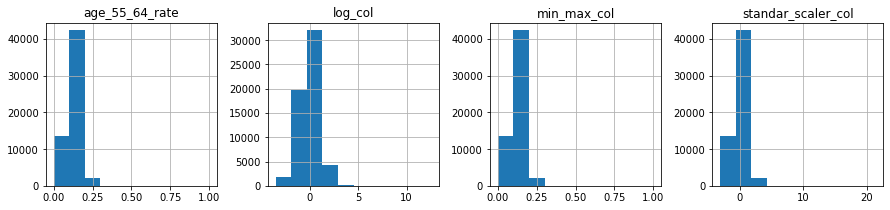

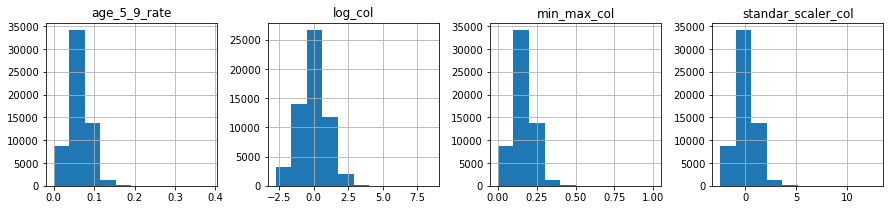

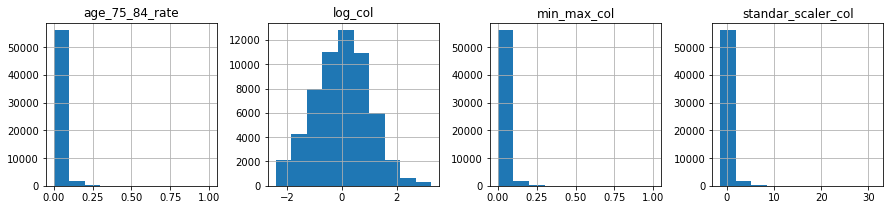

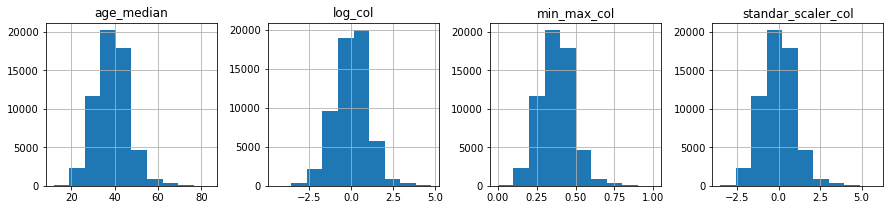

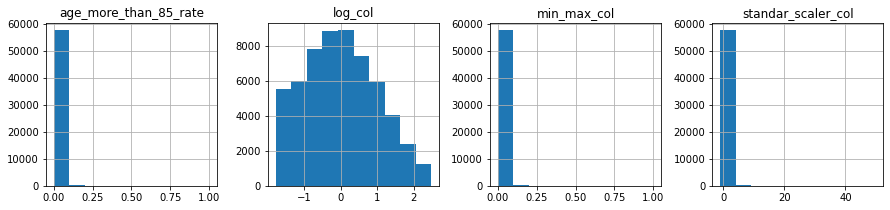

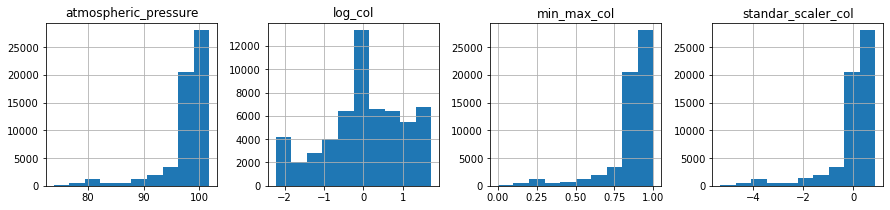

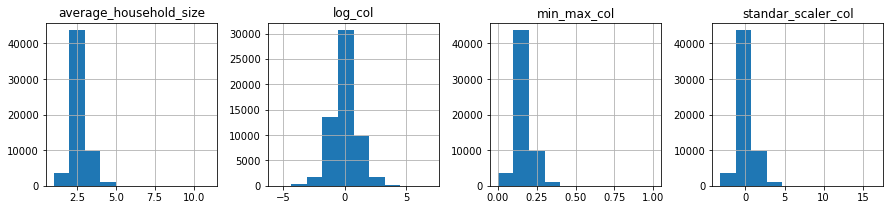

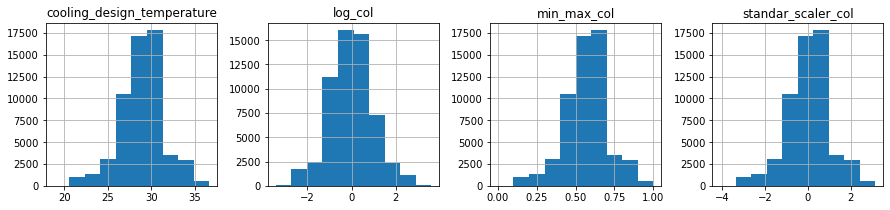

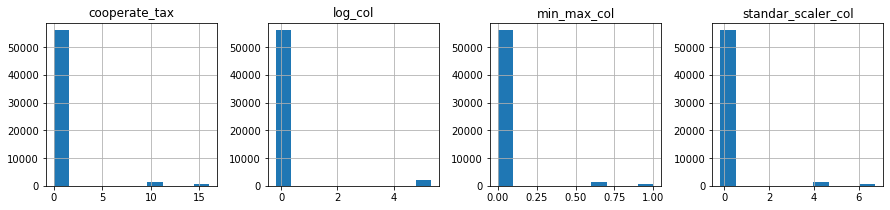

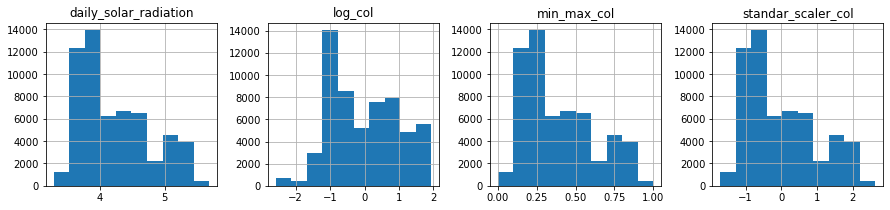

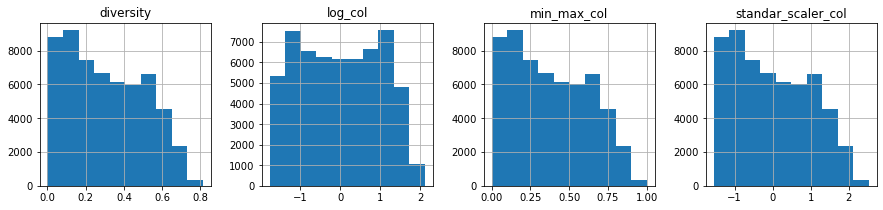

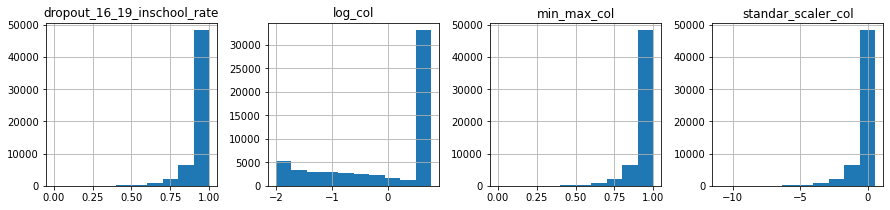

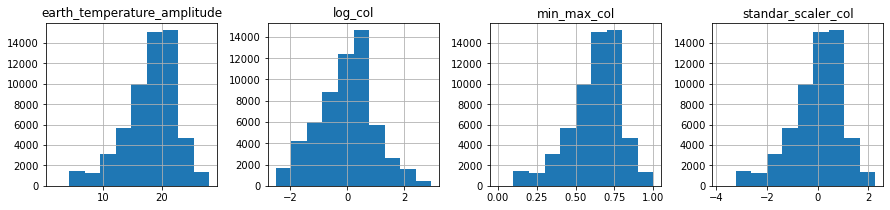

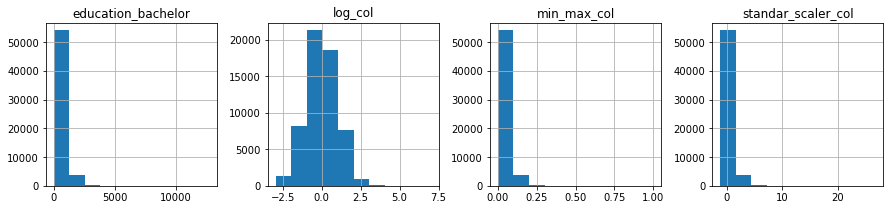

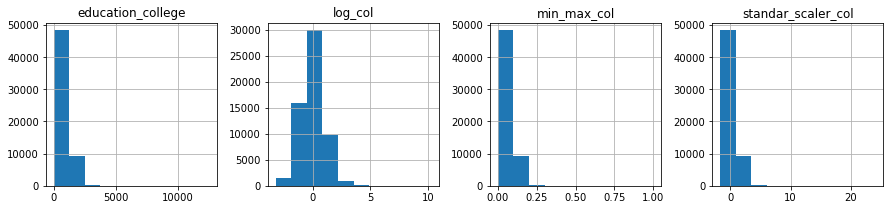

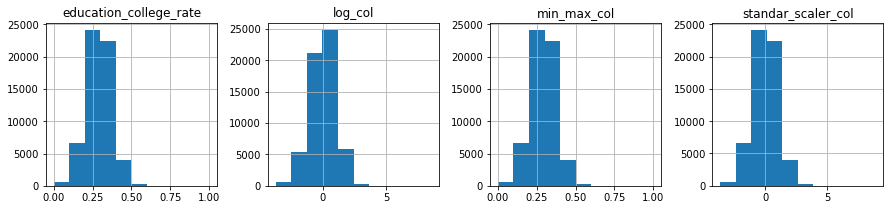

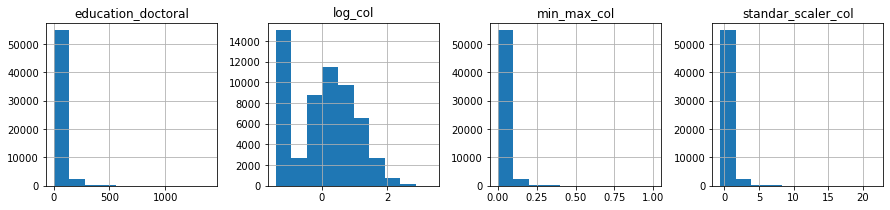

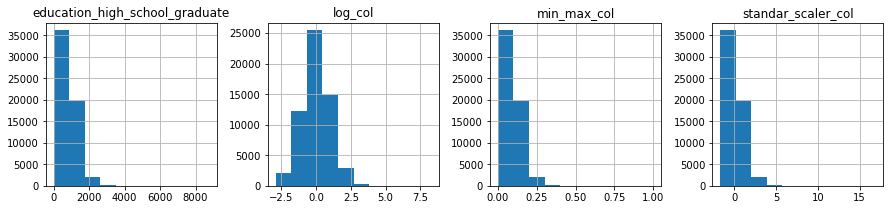

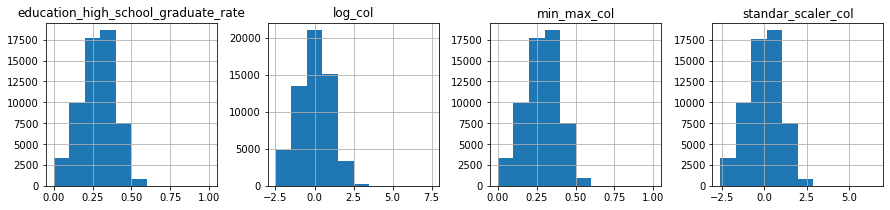

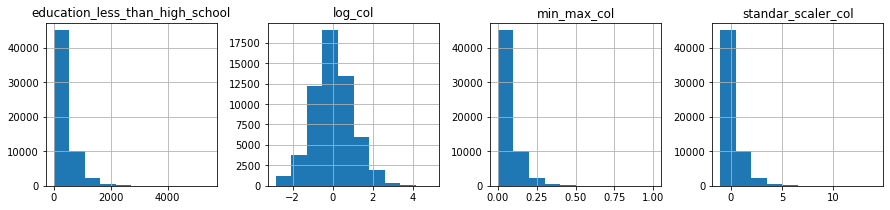

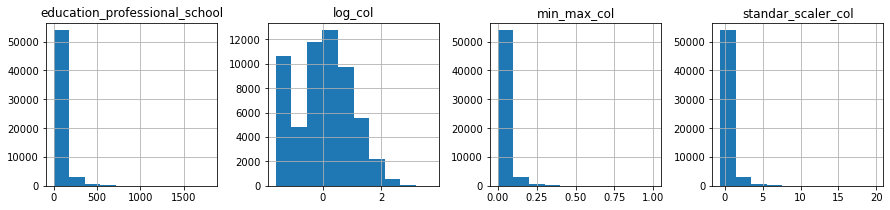

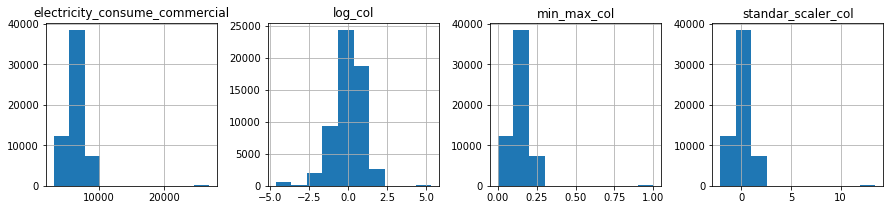

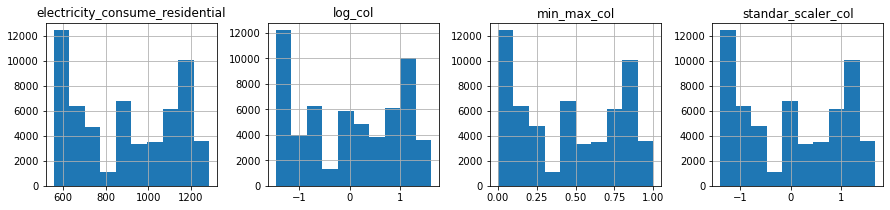

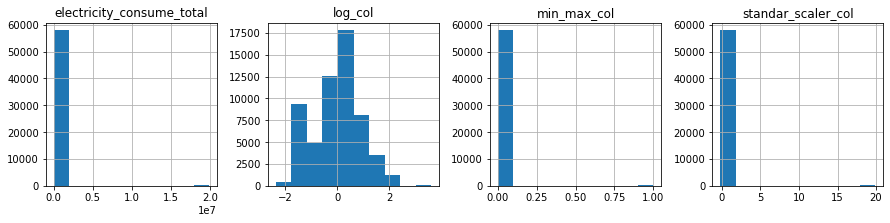

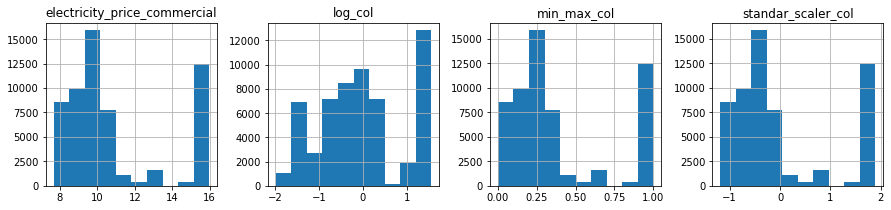

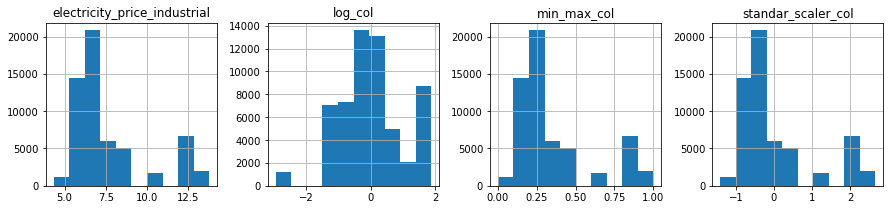

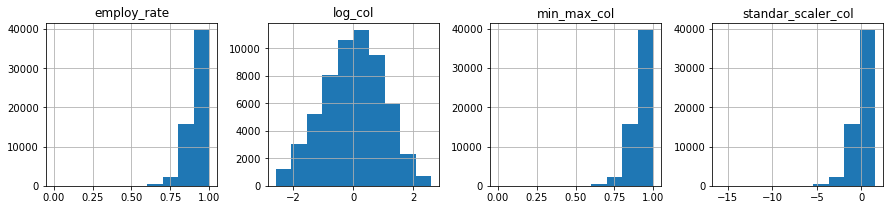

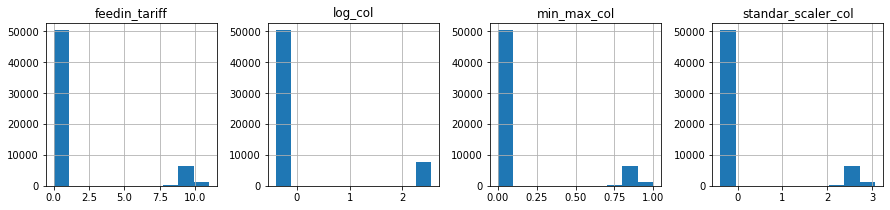

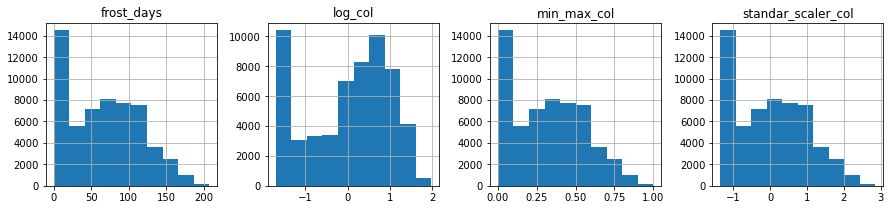

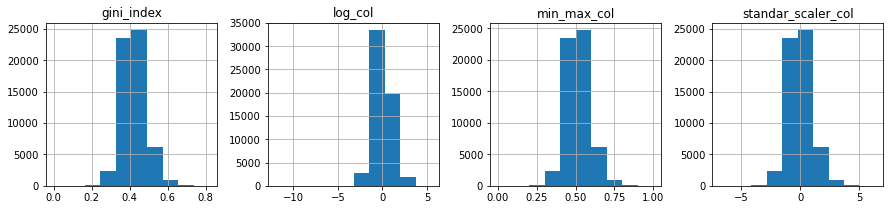

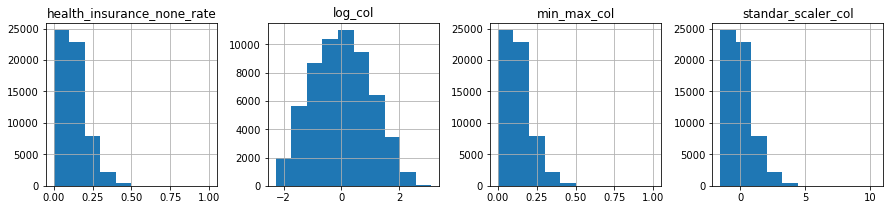

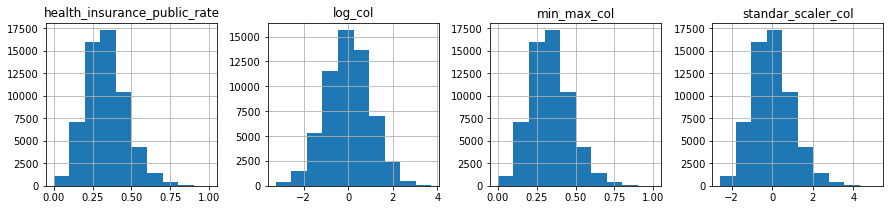

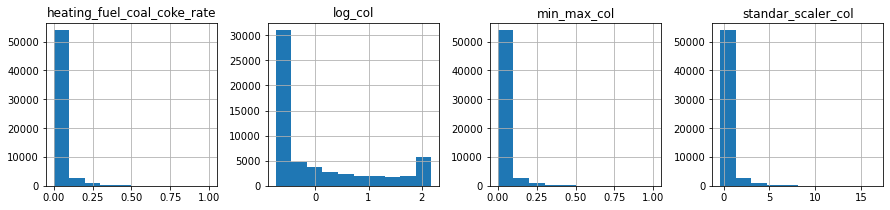

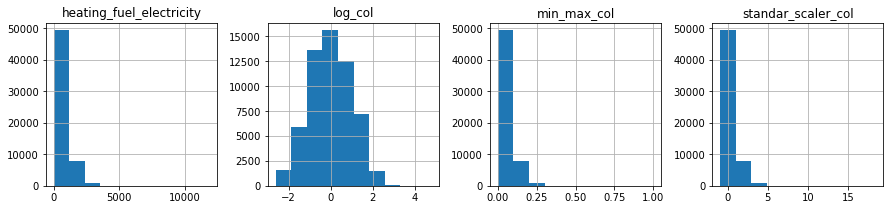

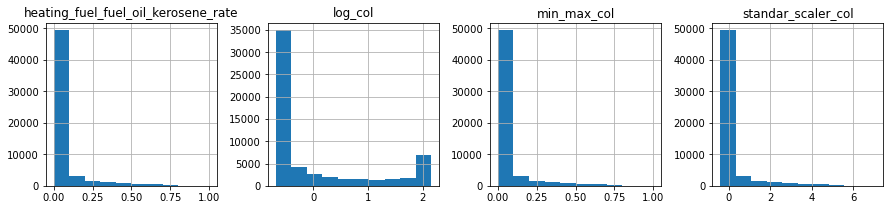

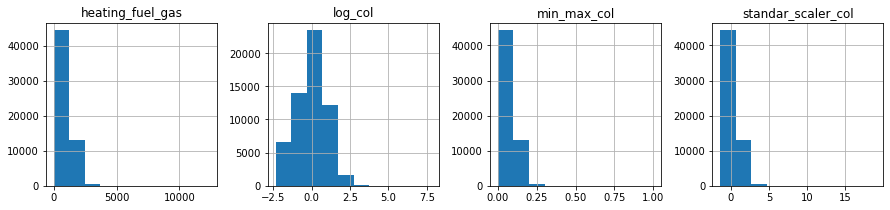

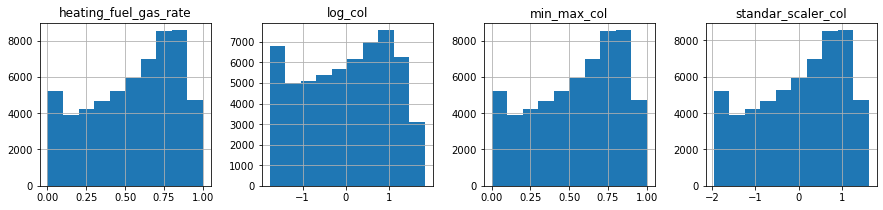

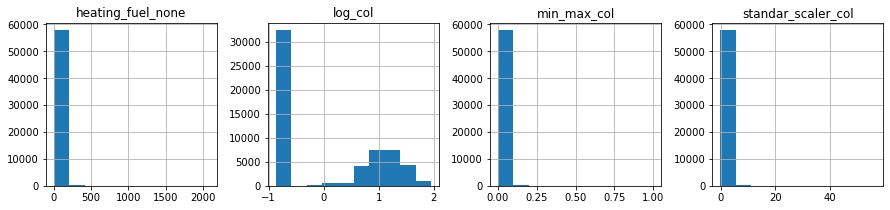

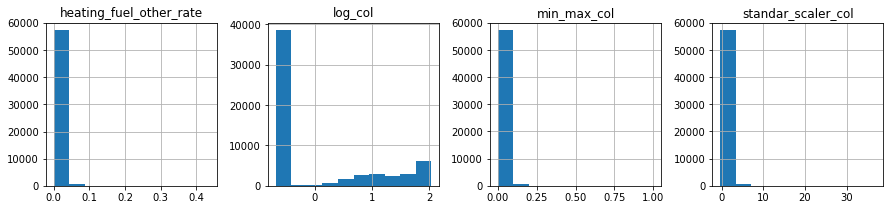

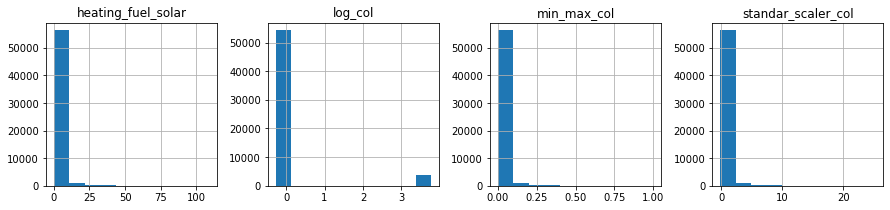

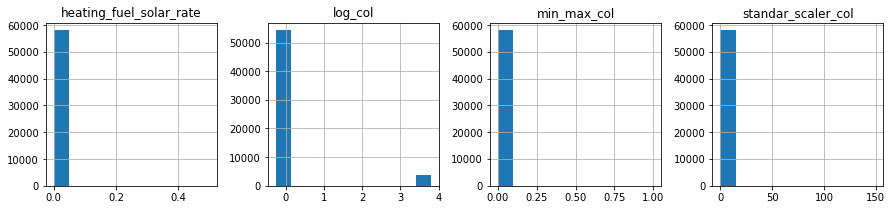

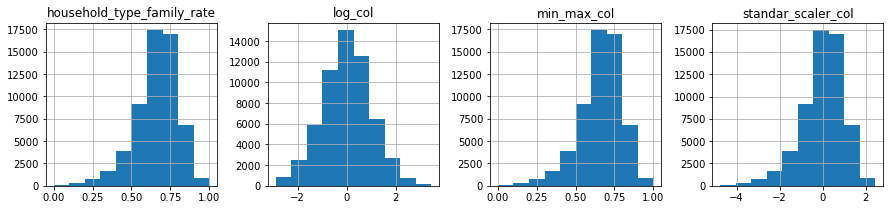

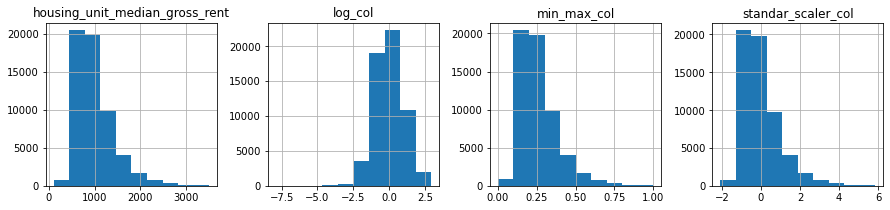

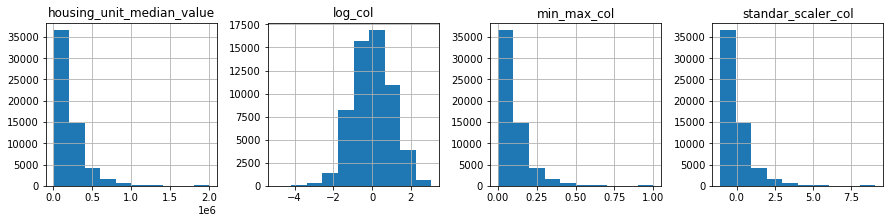

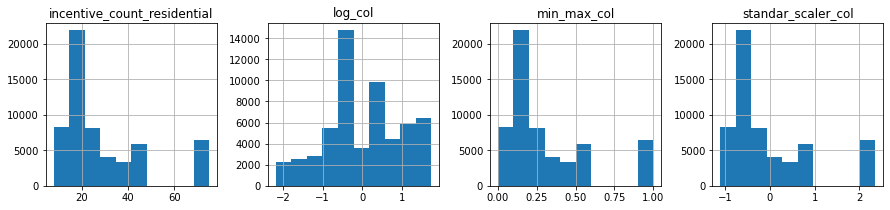

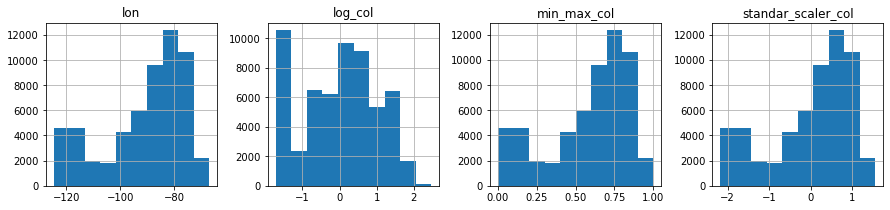

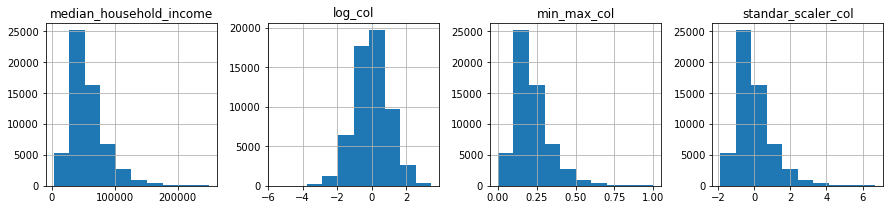

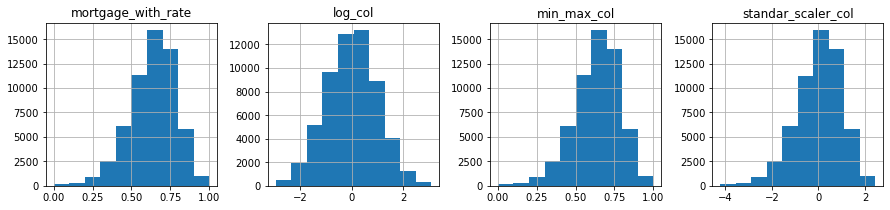

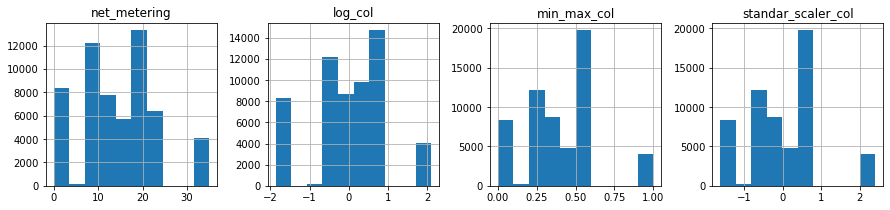

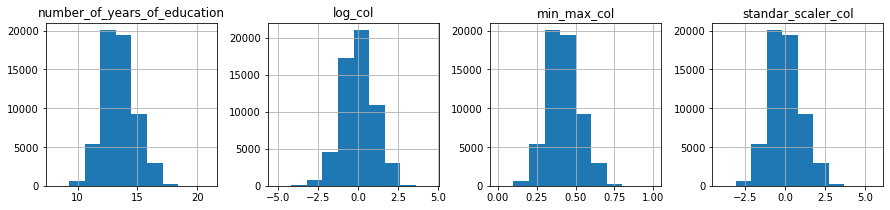

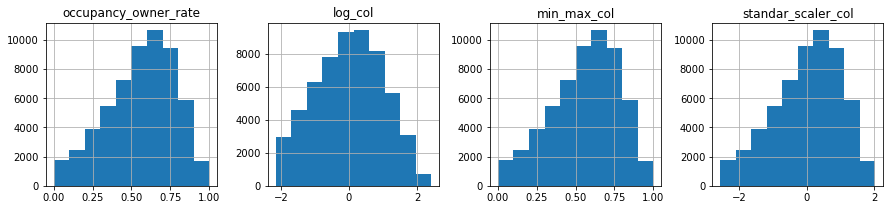

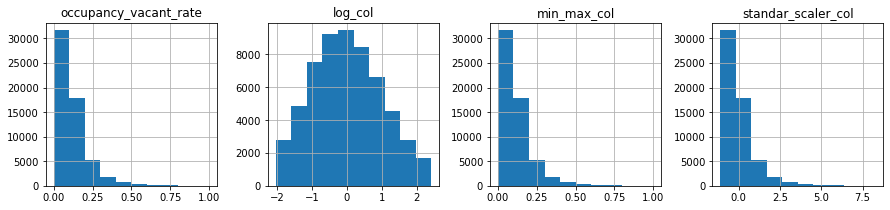

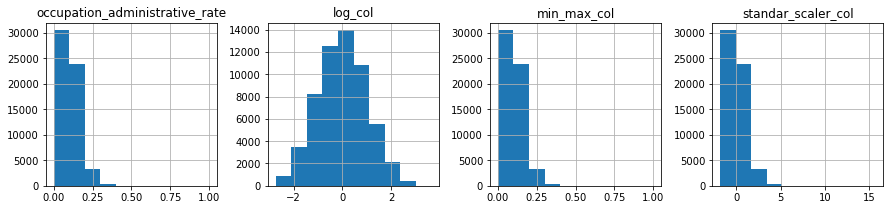

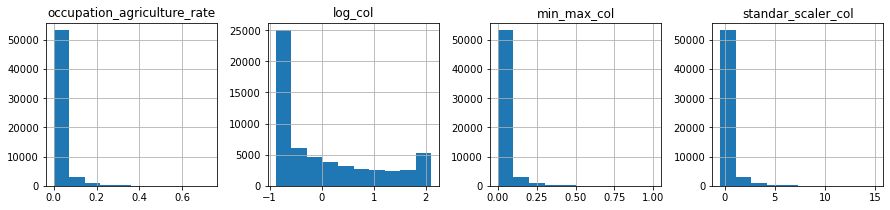

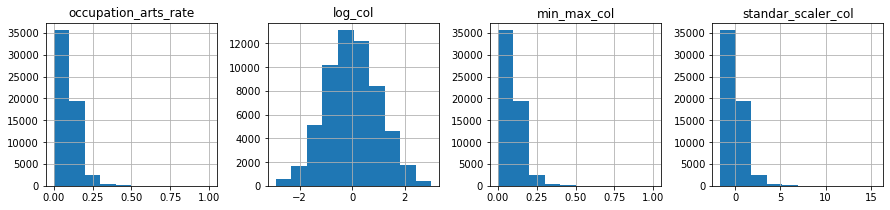

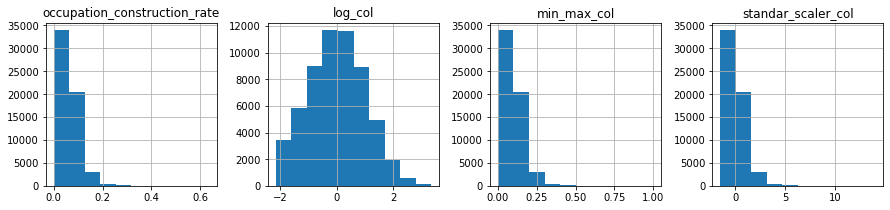

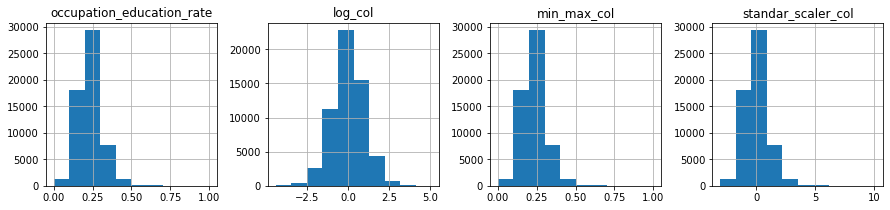

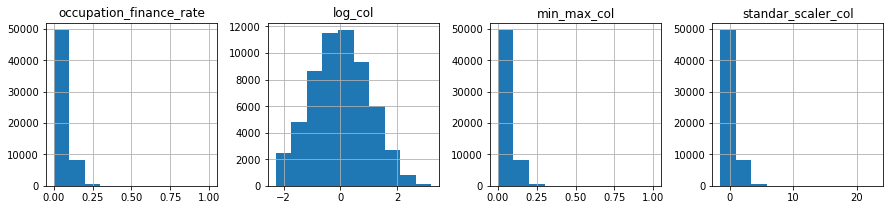

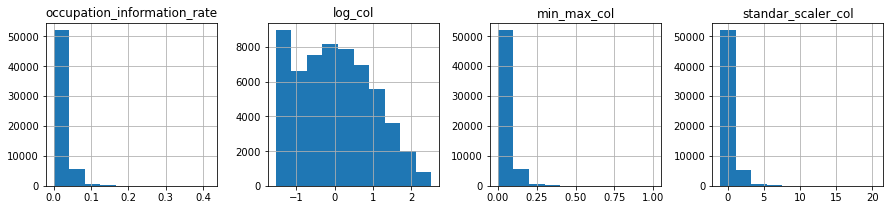

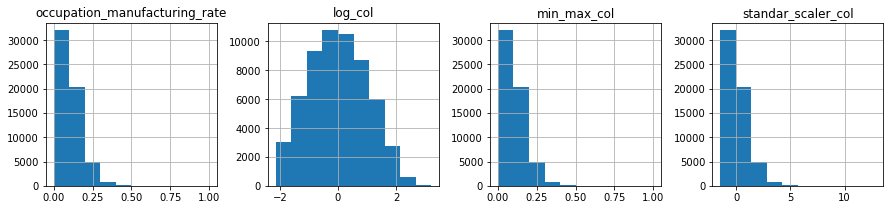

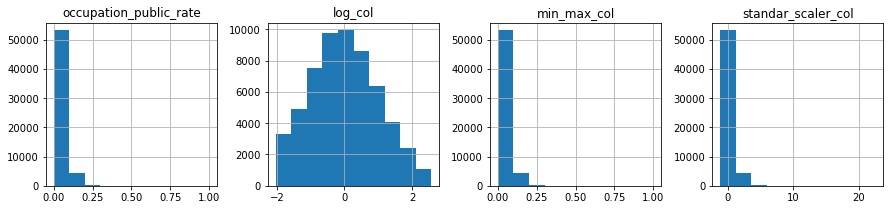

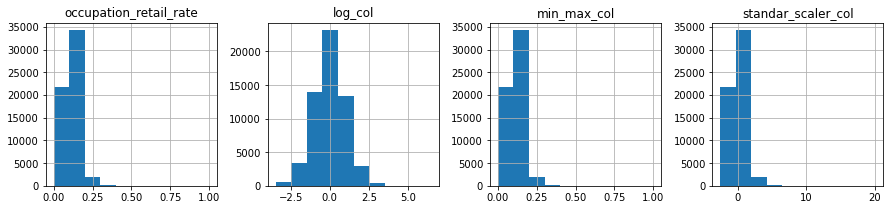

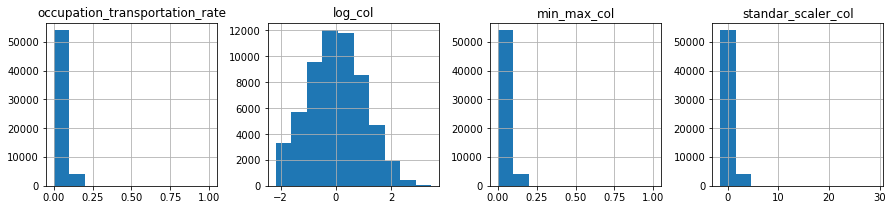

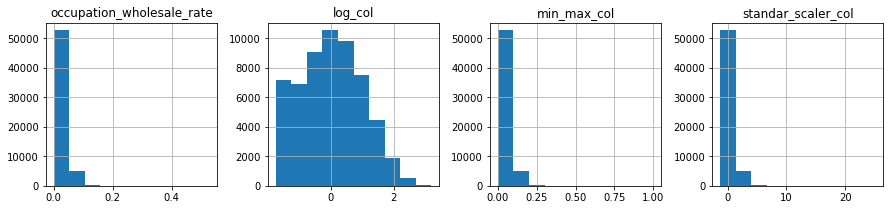

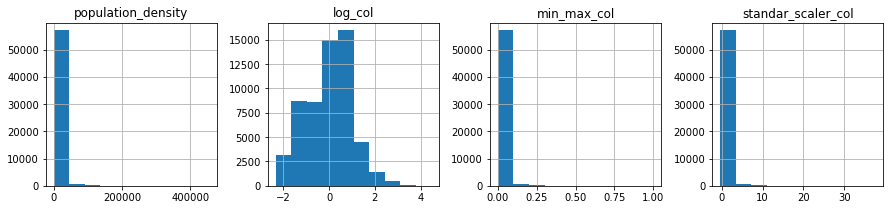

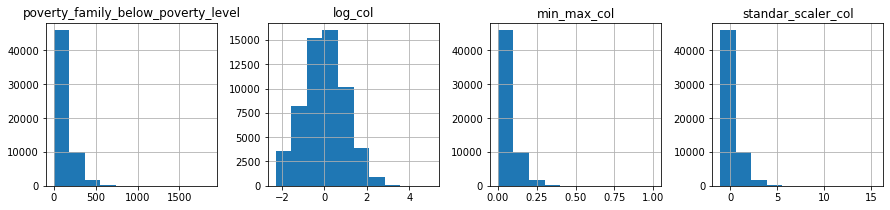

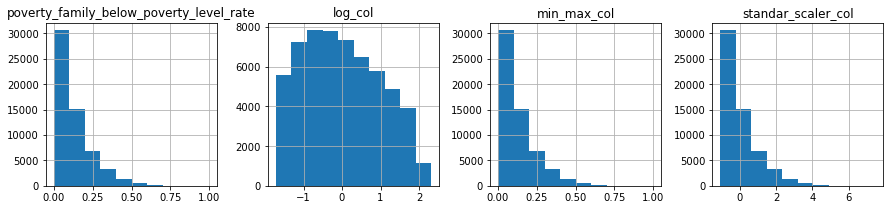

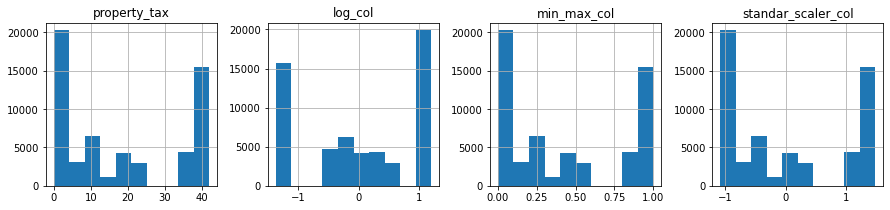

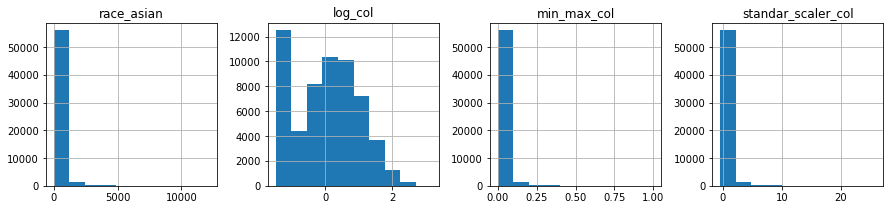

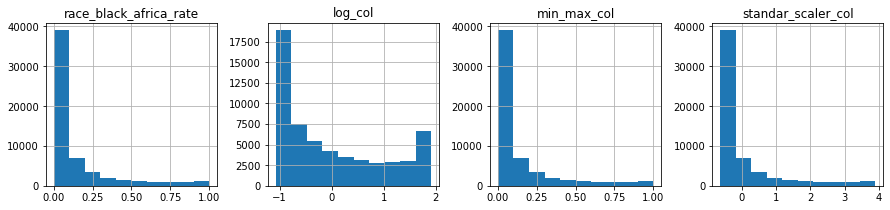

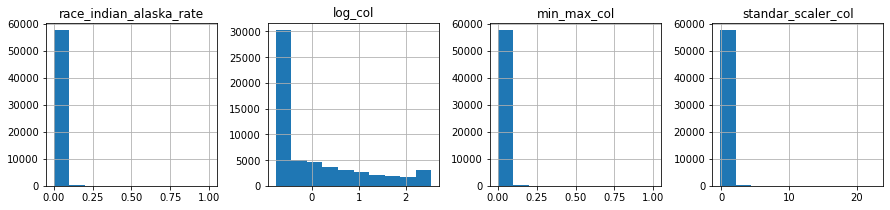

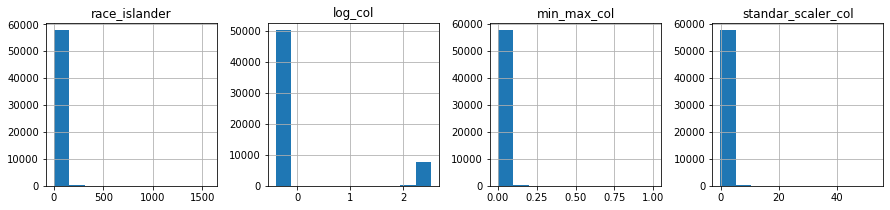

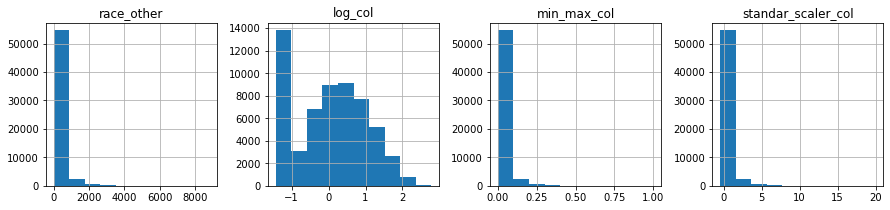

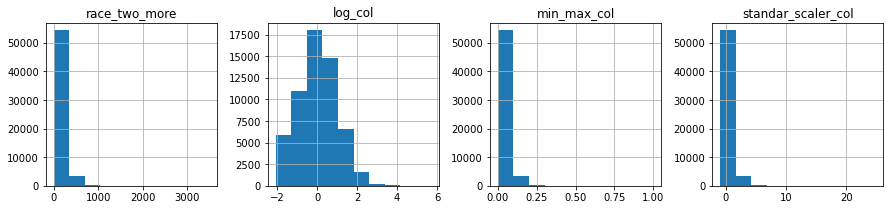

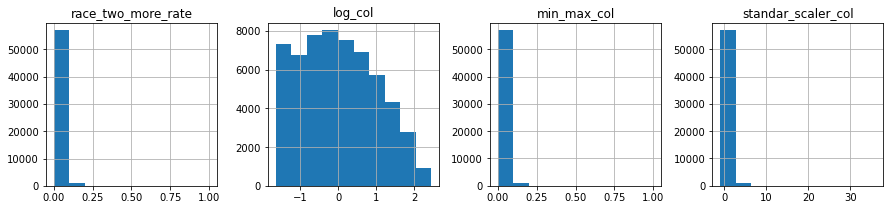

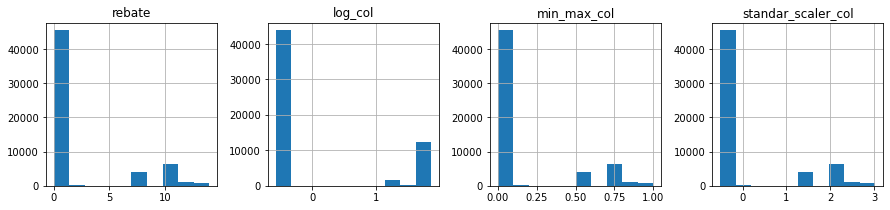

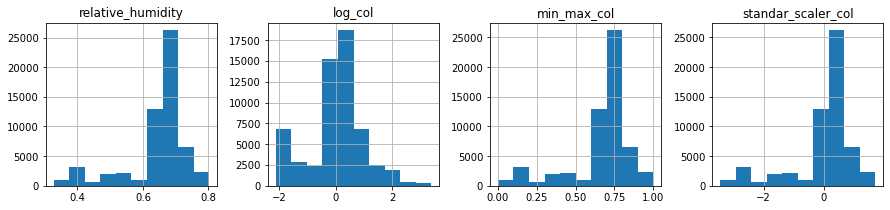

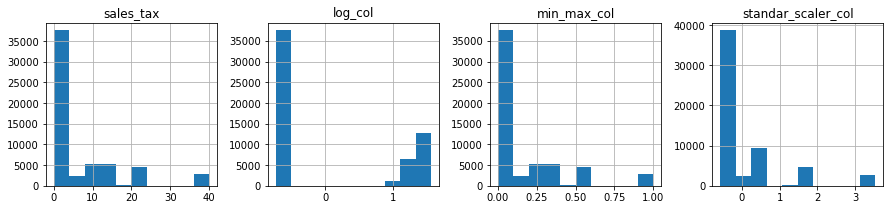

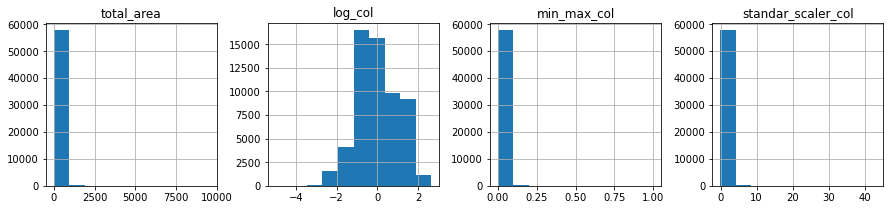

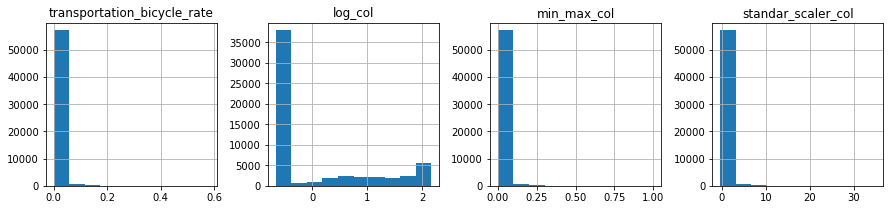

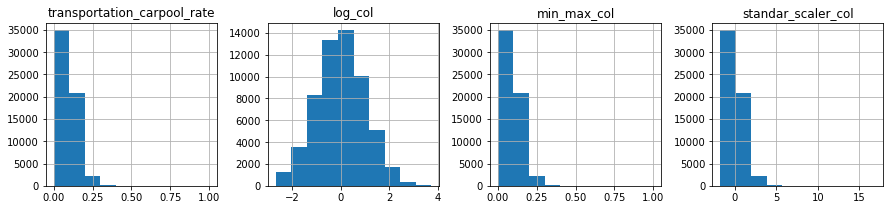

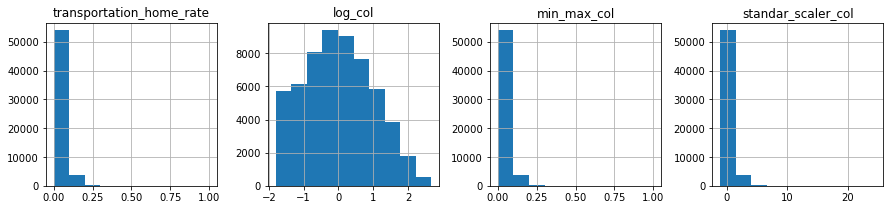

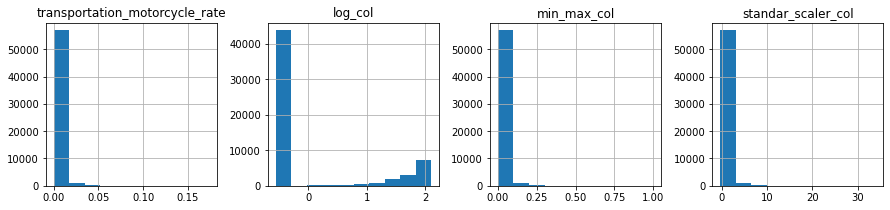

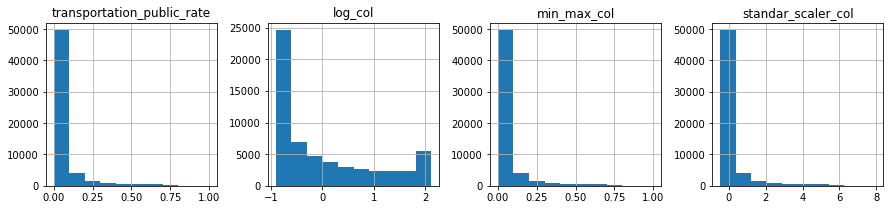

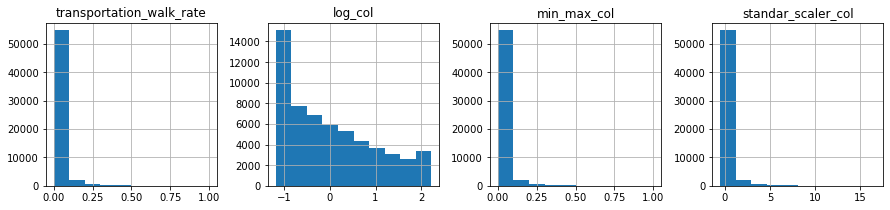

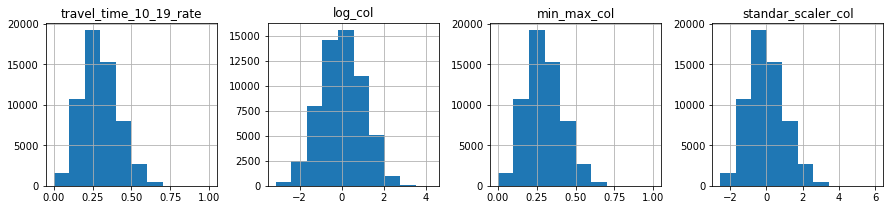

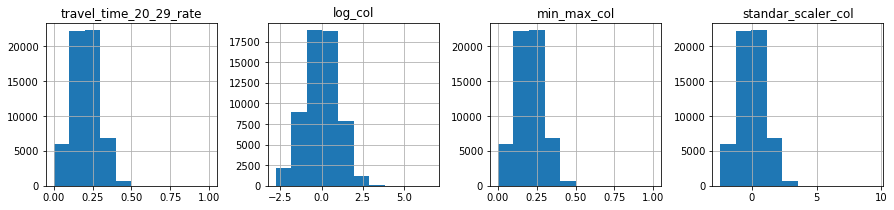

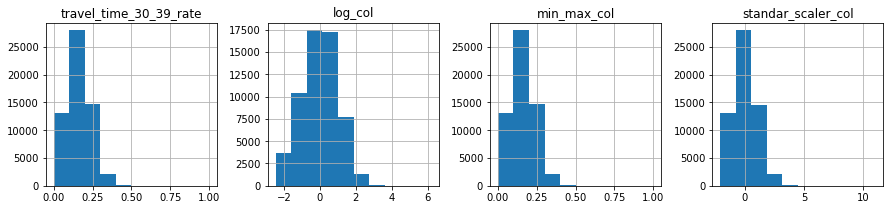

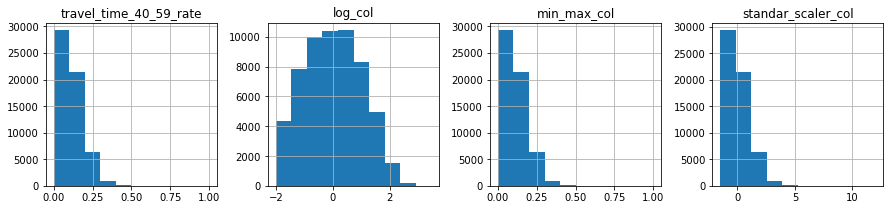

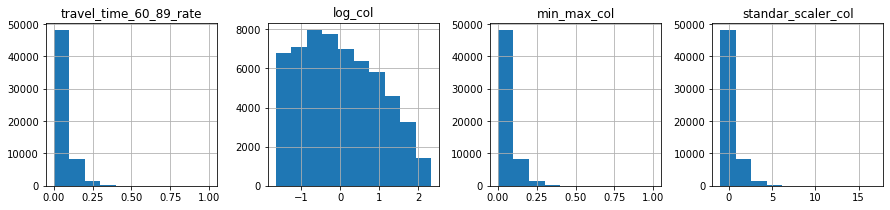

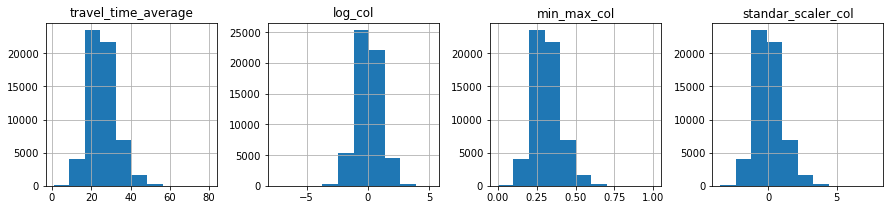

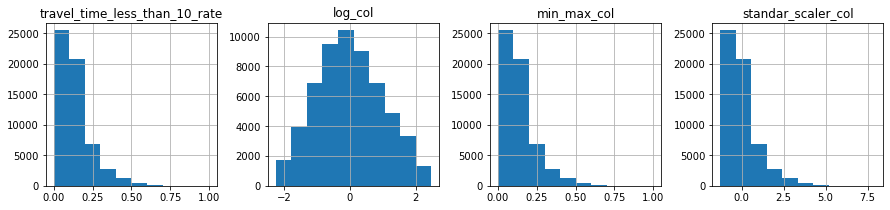

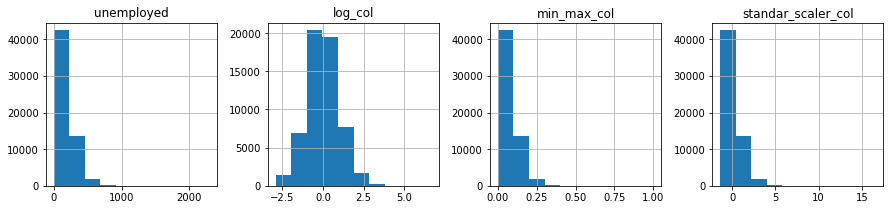

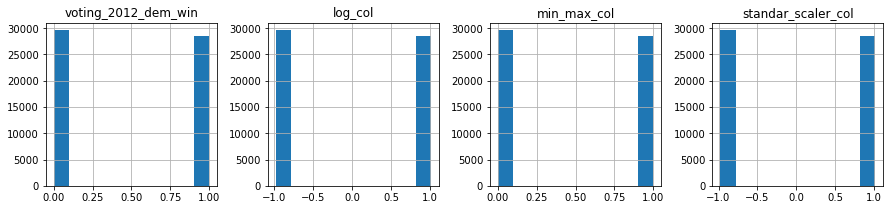

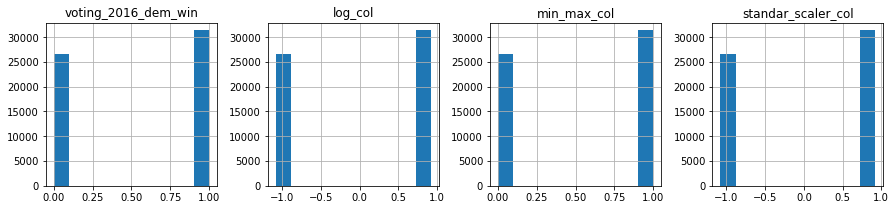

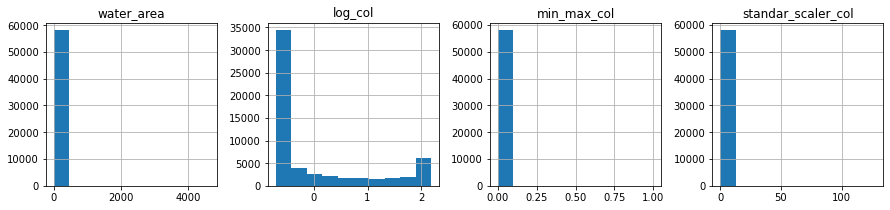

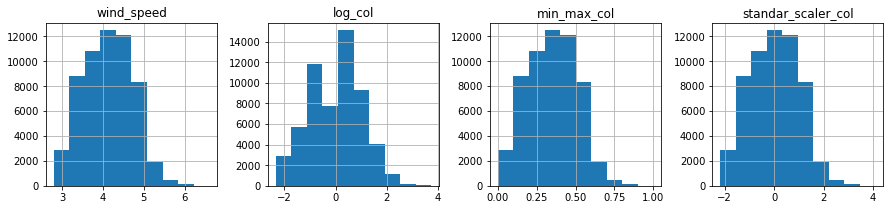

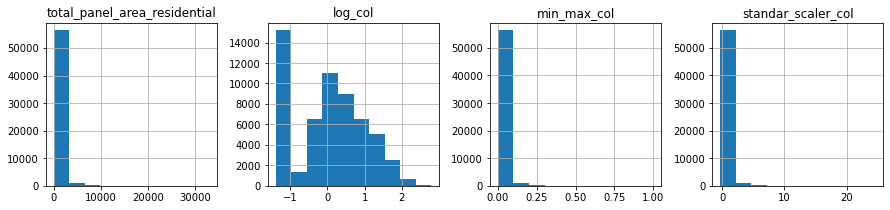

In [33]:
#Investigate distribution of values for numeric columns - determine type of transformation to fix scewness and 
#scale discrepencies in the data
no_plot = list()
for col in list(train_data.select_dtypes(include=[np.number]).columns.values):
    try:
        transformation_comparison(train_data, col)
    except:
        no_plot.append(col)
        continue

In [34]:
no_plot

[]

From the distributions above, the log transformation does the best job of making the distributions more Gaussian. Will apply this transformation to all of the data.

In [35]:
train_data = train_data.drop(['log_col', 'min_max_col', 'standar_scaler_col'], axis=1)

In [36]:
numeric_cols = list(train_data.select_dtypes(include=[np.number]).columns.values)
pos_cols = [col for col in numeric_cols if train_data[col].min() > 0 and test_data[col].min() > 0 and col not in no_plot]
nonpos_cols = [col for col in numeric_cols if col not in pos_cols and col not in no_plot and col != target_var]

#Use box-cox method to transform positive columns
pt = PowerTransformer('box-cox')
print(pt.fit(train_data[pos_cols]))
train_data[pos_cols] = pt.transform(train_data[pos_cols])
test_data[pos_cols] = pt.transform(test_data[pos_cols])

#Use yeo-johnson method to transform columns with negative values
pt2 = PowerTransformer('yeo-johnson')
print(pt2.fit(train_data[nonpos_cols]))
train_data[nonpos_cols] = pt2.transform(train_data[nonpos_cols])
test_data[nonpos_cols] = pt2.transform(test_data[nonpos_cols])

PowerTransformer(method='box-cox')
PowerTransformer()


In [53]:
#Define variables that may potentially provide additional information about the target variable. Will need
#to remove these look ahead variables so the model is not cheating when it makes its predictions
look_ahead_vars = ['tile_count', 'solar_system_count', 'tile_count_residential', 'tile_count_nonresidential',
                  'solar_system_count_residential', 'solar_system_count_nonresidential', 'total_panel_area',
                   'total_panel_area_residential', 'total_panel_area_nonresidential',
                   'solar_panel_area_divided_by_area', 'solar_panel_area_per_capita',
                   'number_of_solar_system_per_household']

In [53]:
df_classification = df.copy()
df_classification['tile_present'] = np.where(df_classification['tile_count'] > 0, 1, 0)
df_classification = df_classification.drop(look_ahead_vars, axis=1)
#Define the binary target variable for classification model
binary_var = 'tile_present'
#Separate data into x and y
x = df_classification[df_classification.columns.difference([binary_var])]
y = df_classification[binary_var]

In [56]:
target_var = 'total_panel_area_residential'
#look_ahead_vars.remove('total_panel_area_residential')
#df_regression = df.drop(look_ahead_vars, axis=1)
#Separate data into x and y
x_reg = df_regression[df_regression.columns.difference([target_var])]
y_reg = df_regression[target_var]

In [38]:
target_var = 'total_panel_area_residential'
train_labels = train_data[target_var]
train_data = train_data[train_data.columns.difference([target_var])]

In [40]:
target_var = 'total_panel_area_residential'
test_labels = test_data[target_var]
test_data = test_data[test_data.columns.difference([target_var])]

# Model Creation

## XGBoost Model Residential

In [42]:
#======================================================
# setup model parameters, choose RFR or XGB
# if you comment out a parameter it will use default value
#======================================================

# XGB parameters (extreme gradient boosting)
params_xgb = {'objective': 'reg:squarederror',
              #'base_score': 0.5,     # chosen as median of validation set
              'n_estimators': 1000,  # number of trees to use
              'learning_rate': 0.01, 
              'max_depth': 30,       # how many levels are in each tree
              #'subsample': 1,
              #'colsample_bytree': 0.8,
              # REGULARIZATION  alpha (L2) and lambda (L1)
              'reg_alpha': 1,
              'reg_lambda': 0,}

In [43]:
#======================================================
# define the model, uncomment the one you want to use
#======================================================
#model = RandomForestRegressor(**params_rfr)
model = XGBRegressor(**params_xgb)

In [44]:
%%time
model.fit(train_data, train_labels)

CPU times: user 2h 25min 48s, sys: 2min 53s, total: 2h 28min 41s
Wall time: 24min 42s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=30, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=1,
             reg_lambda=0, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

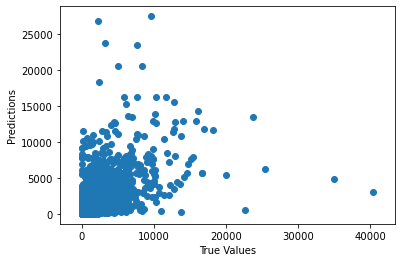

In [53]:
test_predictions = model.predict(test_data)

_ = plt.scatter(test_labels, test_predictions)
_ = plt.xlabel('True Values')
_ = plt.ylabel('Predictions')
_ = plt.axis('equal')
_ = plt.xlim(plt.xlim())
_ = plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

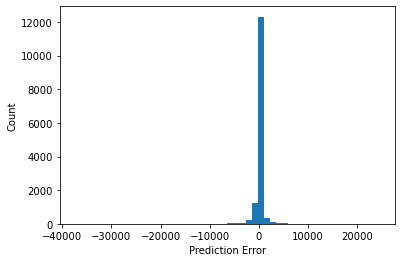

In [61]:
# histogram
error = test_predictions - test_labels
_ = plt.hist(error, bins = 50)
_ = plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

In [63]:
mse = round(mean_squared_error(test_labels, test_predictions)
print(f'the mse is {mse}')

the mse is 1161566.0


In [83]:
def plot_feature_importance(importance, names):
    '''
    this code is from here: 
    https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
    '''
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df[fi_df['feature_importance'] > .01]
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    return(fi_df)

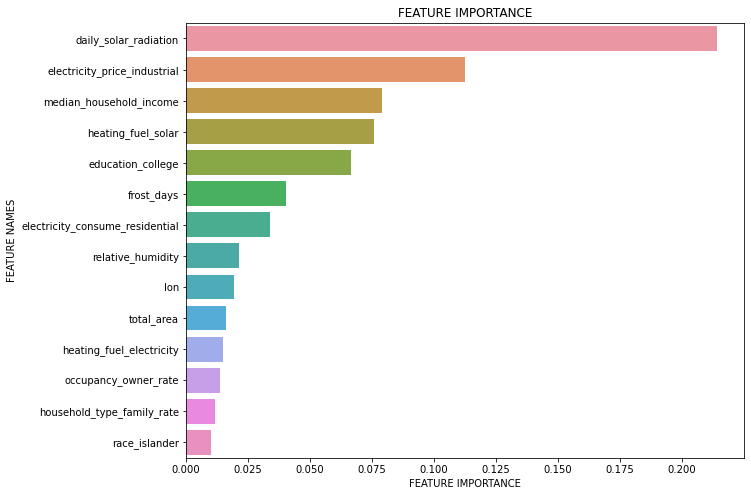

In [84]:
fi_xgboost = plot_feature_importance(model.feature_importances_, train_data.columns)

In [67]:
#Save model
pickle.dump(model, open('/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/models/residential/xgboost_residential.sav', 'wb'))


In [68]:
#load saved model
#loaded_model = pickle.load(open('/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/models/residential/xgboost_residential.sav', 'rb'))
# plot_feature_importance(loaded_model.feature_importances_, train_data.columns)

In [88]:
#Make the data smaller
train_data_small = train_data[list(fi_xgboost['feature_names'])]
test_data_small = test_data[list(fi_xgboost['feature_names'])]

In [90]:
#======================================================
# define the model, uncomment the one you want to use
#======================================================
#model = RandomForestRegressor(**params_rfr)
model_small = XGBRegressor(**params_xgb)


In [91]:
%%time
model_small.fit(train_data_small, train_labels)

CPU times: user 34min 57s, sys: 3min 44s, total: 38min 42s
Wall time: 12min 38s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=30, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=1,
             reg_lambda=0, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [93]:
test_predictions_small = model_small.predict(test_data_small)
mse = round(mean_squared_error(test_labels, test_predictions_small))
print(f'the mse is {mse}')

the mse is 1005593


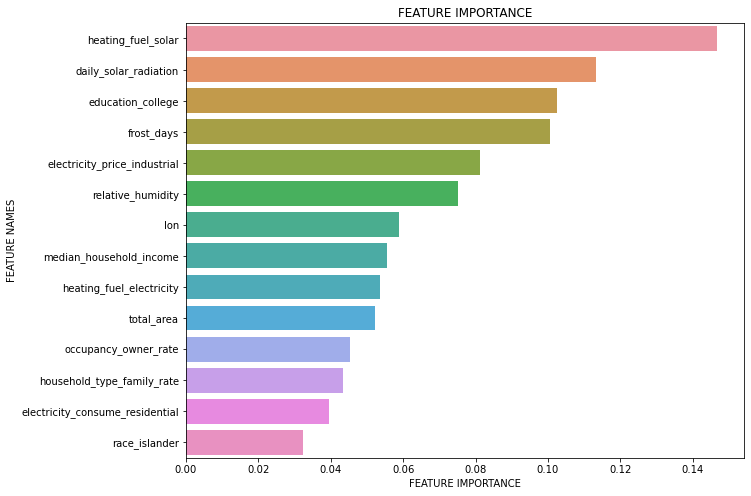

In [94]:
fi_xgboost_small = plot_feature_importance(model_small.feature_importances_, train_data_small.columns)

In [ ]:
import shap
explainer = shap.TreeExplainer(model_small)
shap_values = explainer.shap_values(train_data_small, approximate=True)
shap.summary_plot(shap_values, features=train_data_small, feature_names=train_data_small.columns)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [ ]:
parameters = {'objective':['reg:squarederror'],
              'booster':['gbtree','gblinear'],
              'learning_rate': [0.1], 
              'max_depth': [7,10,15,20],
              'min_child_weight': [10,15,20,25],
              'colsample_bytree': [0.8, 0.9, 1],
              'n_estimators': [300,400,500,600],
              "reg_alpha"   : [0.5,0.2,1],
              "reg_lambda"  : [2,3,5],
              "gamma"       : [1,2,3]}
random_search = RandomizedSearchCV(estimator=model, param_distributions=parameters,
                                           n_iter=100, cv=strat_kfold.split(x, y), verbose=3, random_state=seed,
                                           n_jobs=-1, scoring = 'neg_mean_absolute_error')
random_search.fit(train_data, train_labels)
return(random_search.best_params_)

<AxesSubplot:>

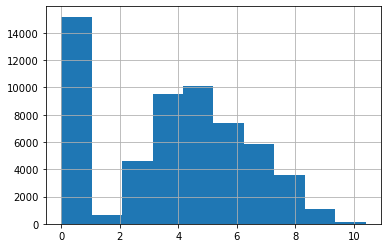

In [66]:
np.log(train_labels + 1).hist()

In [71]:
#Log transform the target
#======================================================
# define the model, uncomment the one you want to use
#======================================================
#model = RandomForestRegressor(**params_rfr)
model = XGBRegressor(**params_xgb)
train_labels = np.log(train_labels+1)
test_labels = np.log(test_labels+1)

In [72]:
%%time
model.fit(train_data, train_labels)

CPU times: user 1h 38min 59s, sys: 1min 1s, total: 1h 40min
Wall time: 14min 9s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=30, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=1,
             reg_lambda=0, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

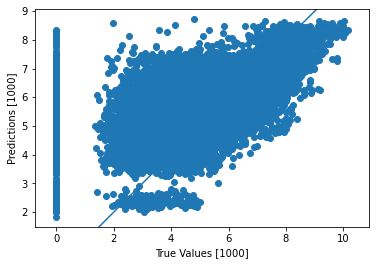

In [73]:
test_predictions = model.predict(test_data)

_ = plt.scatter(test_labels, test_predictions)
_ = plt.xlabel('True Values [1000]')
_ = plt.ylabel('Predictions [1000]')
_ = plt.axis('equal')
_ = plt.xlim(plt.xlim())
_ = plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

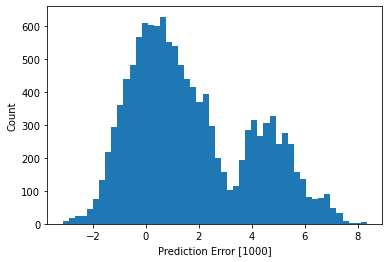

In [74]:
# histogram
error = test_predictions - test_labels
_ = plt.hist(error, bins = 50)
_ = plt.xlabel("Prediction Error [1000]")
_ = plt.ylabel("Count")

In [76]:
mse = np.exp(mean_squared_error(test_labels, test_predictions))
print(f'the mse is {mse}')

the mse is 3014.318615458034


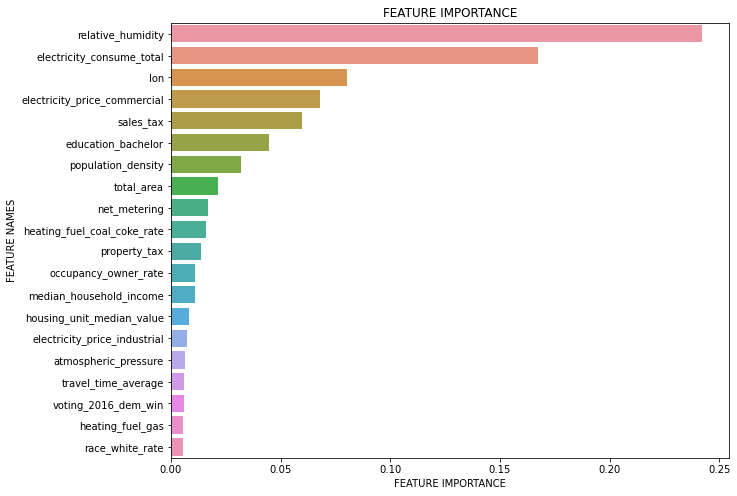

In [77]:
plot_feature_importance(model.feature_importances_, train_data.columns)

In [ ]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_data)
shap.summary_plot(shap_values, features=train_data, feature_names=train_data.columns)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


## Random Forest Model

In [58]:
#Ensure all columns are numeric
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61956 entries, 0 to 72536
Columns: 153 entries, age_10_14_rate to wind_speed
dtypes: float64(153)
memory usage: 72.8 MB


In [59]:
#Split the encoded data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y,test_size=0.2, random_state=seed)

In [60]:
#Define random_grid for parameter tuning random search
random_grid = {'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
                          'max_features': ['auto', 'sqrt'],
                          'max_depth': [int(x) for x in np.linspace(100, 110, num=2)],
                          'min_samples_split': [2, 5, 10],
                          'min_samples_leaf': [1, 2, 5],
                          'bootstrap': [True, False],
                          'class_weight': ['balanced']}

In [63]:
#Run a random search of Random Forest parameters to find best initial hyper parameters. Use stratified k-fold
#cross-validation in randomsearch
#params = parameter_tuning.randomsearch(seed, x_train, y_train, random_grid, 'rf')

In [30]:
print(params)

{'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 110, 'class_weight': 'balanced', 'bootstrap': False}


In [31]:
#Define random grid for grid search parameter tuning
random_grid = {'n_estimators': [600, 700],
                          'max_features': ['auto','sqrt'],
                          'max_depth': [110],
                          'min_samples_split': [4, 5, 6],
                          'min_samples_leaf': [5, 6],
                          'bootstrap': [False],
                          'class_weight': ['balanced']}

In [32]:
#Run a more intensive grid search to tune hyper parameters for Random Forest Model.  Use stratified k-fold
#cross-validation in randomsearch
params = parameter_tuning.gridsearch(seed, x_cat, y, random_grid, 'rf')

Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  1.1min finished


In [64]:
params = {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 110, 'max_features': 'auto', 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 700}
print(params)

{'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 110, 'max_features': 'auto', 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 700}


In [65]:
#Run the preliminary Random Forest Model
rf_mod = models.rf_model(x_train, y_train, seed, **params)

In [67]:
#Explore feature importance
rf_mod_imp = pd.DataFrame({'Gini-importance': rf_mod.feature_importances_, 'col': x_train.columns})
rf_mod_imp = rf_mod_imp.sort_values(['Gini-importance', 'col'], ascending=False)
#Keep features with a Gini-importance >= 0.01
rf_mod_imp = rf_mod_imp[rf_mod_imp['Gini-importance'] >= 0.01]
print(rf_mod_imp)

     Gini-importance                                   col
86          0.035320                                   lon
41          0.033549        electricity_consume_industrial
45          0.031015          electricity_price_industrial
43          0.029731             electricity_consume_total
127         0.028793                     relative_humidity
107         0.026549                    population_density
84          0.025599                             land_area
129         0.025135                            total_area
20          0.023203                 daily_solar_radiation
25          0.017076                    education_bachelor
83          0.016116     incentive_residential_state_level
81          0.015872           incentive_count_residential
46          0.015565             electricity_price_overall
44          0.015504          electricity_price_commercial
35          0.015358                      education_master
78          0.014335             housing_unit_median_val

In [68]:
#Keep top importance features in the x data
x_rf_imp = x[rf_mod_imp['col']]
x_train_rf_imp = x_train[rf_mod_imp['col']]
x_test_rf_imp = x_test[rf_mod_imp['col']]

In [70]:
#Run Random Forest model with only important features
rf_mod = models.rf_model(x_train_rf_imp, y_train, seed, **params)

In [71]:
#Use Random Forest model to make predictions on train and test sets
y_pred_train_rf, y_pred_test_rf = evaluation.predictions(rf_mod, x_train_rf_imp, x_test_rf_imp)

In [72]:
#Examine model performance metrics
rf_results = evaluation.results(y_train, y_test, y_pred_train_rf, y_pred_test_rf)

In [73]:
print(rf_results)

               Test     Train
Metrics                      
AUC        0.831110  0.947696
Accuracy   0.832473  0.948128
F1         0.819384  0.945866
Recall     0.781447  0.931992
Precision  0.861192  0.960159


Random Forest seems to be slightly overfitting. Experiment with XGBoost model to see if there is better performance.

# Neural Network Regression

In [56]:
#Split the encoded data into train and test sets
#x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x_reg, y_reg, test_size=0.2, random_state=seed)


In [35]:
from tensorflow import keras

In [36]:
# Define basic architecture
model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu, #activation=tf.keras.activations.linear,
                       input_shape=(train_data.shape[1],),
                       name='hidden_layer_1',),
#     keras.layers.Dense(128, activation=tf.nn.relu,
#                        name='hidden_layer_2',),
#     keras.layers.Dense(128, activation=tf.nn.relu,
#                        name='hidden_layer_3',),
    #keras.layers.Dense(16, activation=tf.nn.relu,
    #                   input_shape=(16,),
    #                   name='hidden_layer_2',),
    keras.layers.Dense(1, name='output_layer',)
])

# Define your optimizer asdf
#optimizer = tf.train.AdamOptimizer()
optimizer = tf.optimizers.Adam()

model.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mae'])

# show a summary of the data
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 128)               12672     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 129       
Total params: 12,801
Trainable params: 12,801
Non-trainable params: 0
_________________________________________________________________


2021-12-12 16:22:46.453371: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [37]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
        
# Function to plot how the model is doing during training
# Visualize the model's training progress using the stats stored in the history object. 
# We want to use this data to determine how long to train before the model stops making progress.
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [1000]')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()
    #plt.ylim([0, 5])

2021-12-12 16:23:15.523356: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)



....................................................................................................
....................................................................................................
....................................................................................................
...........................................................

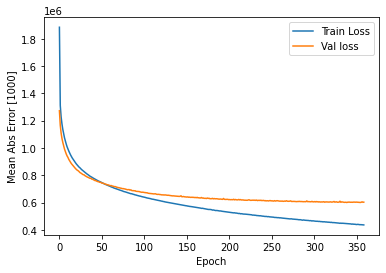

In [38]:
# If you train too long, you are prone to over-fitting
# this prevents the model from generalizing to data it has never seen before
# early stopping is one way to go about this
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Store training stats
history = model.fit(train_data, train_labels, epochs=1000,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

In [44]:
[loss, mae] = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:7.2f}".format(mae * 1000))

Testing set Mean Abs Error: 3980410500.00


Text(0.5, 0, 'True Values [1000]')

Text(0, 0.5, 'Predictions [1000]')

(-1279.5686754600001, 26870.94218466, -141680509.2, 49868501.2)

(-1279.5686754600001, 26870.94218466)

(-141680509.2, 49868501.2)

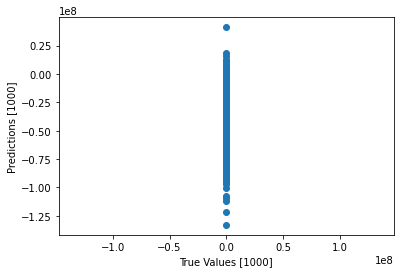

In [45]:
test_predictions = model.predict(test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [1000]')
plt.ylabel('Predictions [1000]')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])